#유기동물 입양 대기기간 예측/분류 모델
(Stray Animal Adoption Prediction)

**8조**

*   2016150434 손호열
*   2017320248 이민성
*   2017250297 최창수






데이터 설명
https://www.kaggle.com/competitions/petfinder-adoption-prediction/data


train.csv: 기본 tabular 데이터

train_metadata: 구글 비전 모델에서 추출한 metadata

train_sentiment: 구글 NLP 모델에서 추출한 sentiment 데이터

train_images: raw iamge 데이터



# 문제설정

문제1: ordinal data인 adoption speed를 어떻게 모델링할건지?(실제로는 quadratic weighted kappa loss 사용하지만 수업시간에 다루지않았으므로 고려x)

방법1: regression 모델, ex. linear regression with MSE loss

방법2: multiclass classification 모델, ex. softmax regression with cross entropy loss

두가지 모두 사용하여 모델링 한 후에, MSE, MAE, ACC등의 metric을 동시에 비교하기

# Configuration/data preparation

In [ ]:
BASE_SRC = '/content' #필요시 수정해서 drive로 연동하세요.(매번 다운로드 안받게)

In [ ]:
cd {BASE_SRC}

/content


In [ ]:
pwd

'/content'

In [ ]:
!nvidia-smi

Mon Dec 19 12:17:45 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.73.05    Driver Version: 510.73.05    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:00:05.0 Off |                    0 |
| N/A   40C    P0    46W / 300W |      0MiB / 81920MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip3 -q install --upgrade gdown
!pip -q install plotly
!pip -q install tensorflow-addons
!pip -q install timm
!pip -q install tfimm

     |████████████████████████████████| 1.1 MB 15.0 MB/s 
     |████████████████████████████████| 549 kB 15.2 MB/s 
     |████████████████████████████████| 182 kB 79.4 MB/s 
     |████████████████████████████████| 155 kB 15.0 MB/s 


In [ ]:
import tensorflow as tf
import tensorflow_addons as tfa
import tfimm
import pandas as pd
import numpy as np
import sklearn

import random
import os
import warnings
from tqdm.auto import tqdm
import glob
from PIL import Image
import json
import pprint

from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.io as plt_io
import plotly.graph_objects as go
import plotly.express as px
%matplotlib inline

In [ ]:
SEED = 111
# Function to seed everything
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)
seed_everything(SEED)

In [ ]:
!gdown 130aj1ocgNLkwGXCsdGMUPAncXsqTg_uj
!unzip petfinder-adoption-prediction.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: train_sentiment/a89bfa0aa.json  
  inflating: train_sentiment/a89d4e8f3.json  
  inflating: train_sentiment/a89f8b241.json  
  inflating: train_sentiment/a89fd1f1e.json  
  inflating: train_sentiment/a8a1d4151.json  
  inflating: train_sentiment/a8a2aecc3.json  
  inflating: train_sentiment/a8a3c4f49.json  
  inflating: train_sentiment/a8a8f95f6.json  
  inflating: train_sentiment/a8b358af2.json  
  inflating: train_sentiment/a8b9d57b4.json  
  inflating: train_sentiment/a8ba4dfa1.json  
  inflating: train_sentiment/a8c19a325.json  
  inflating: train_sentiment/a8c336257.json  
  inflating: train_sentiment/a8c555240.json  
  inflating: train_sentiment/a8cdba660.json  
  inflating: train_sentiment/a8ce7d647.json  
  inflating: train_sentiment/a8cfb849e.json  
  inflating: train_sentiment/a8cfbf446.json  
  inflating: train_sentiment/a8d14470d.json  
  inflating: train_sentiment/a8d44452c.json  
  inflating: train_sentiment/a8d9108c4.json 

In [ ]:
!gdown 1LNMW3j8gOY3Tgmo4HFghl0HhZlupBOvK
!unzip -j petfinder_feature_engineering_train.zip

Downloading...
From: https://drive.google.com/uc?id=1LNMW3j8gOY3Tgmo4HFghl0HhZlupBOvK
To: /content/petfinder_feature_engineering_train.zip
100% 2.13M/2.13M [00:00<00:00, 199MB/s]
Archive:  petfinder_feature_engineering_train.zip
replace train_measure_df.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: train_measure_df.csv    
  inflating: train_meta.csv          
  inflating: train_sent.csv          


# EDA

In [ ]:
state_df = pd.read_csv('state_labels.csv')
breed_df = pd.read_csv('breed_labels.csv')
color_df = pd.read_csv('color_labels.csv')

In [ ]:
train_df = pd.read_csv('train/train.csv')
train_df.head()

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed
0,2,Nibble,3,299,0,1,1,7,0,1,...,1,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1.0,2
1,2,No Name Yet,1,265,0,1,1,2,0,2,...,1,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,6296e909a,2.0,0
2,1,Brisco,1,307,0,1,2,7,0,2,...,1,1,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,3422e4906,7.0,3
3,1,Miko,4,307,0,2,1,2,0,2,...,1,1,150,41401,9238e4f44c71a75282e62f7136c6b240,0,"Good guard dog, very alert, active, obedience ...",5842f1ff5,8.0,2
4,1,Hunter,1,307,0,1,1,0,0,2,...,1,1,0,41326,95481e953f8aed9ec3d16fc4509537e8,0,This handsome yet cute boy is up for adoption....,850a43f90,3.0,2


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14993 entries, 0 to 14992
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Type           14993 non-null  int64  
 1   Name           13736 non-null  object 
 2   Age            14993 non-null  int64  
 3   Breed1         14993 non-null  int64  
 4   Breed2         14993 non-null  int64  
 5   Gender         14993 non-null  int64  
 6   Color1         14993 non-null  int64  
 7   Color2         14993 non-null  int64  
 8   Color3         14993 non-null  int64  
 9   MaturitySize   14993 non-null  int64  
 10  FurLength      14993 non-null  int64  
 11  Vaccinated     14993 non-null  int64  
 12  Dewormed       14993 non-null  int64  
 13  Sterilized     14993 non-null  int64  
 14  Health         14993 non-null  int64  
 15  Quantity       14993 non-null  int64  
 16  Fee            14993 non-null  int64  
 17  State          14993 non-null  int64  
 18  Rescue

In [ ]:
train_df.describe()

,Type,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,VideoAmt,PhotoAmt,AdoptionSpeed
count,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000
mean,1.457614,10.452078,265.272594,74.009738,1.776162,2.234176,3.222837,1.882012,1.862002,1.467485,1.731208,1.558727,1.914227,1.036617,1.576069,21.259988,41346.028347,0.056760,3.889215,2.516441
std,0.498217,18.155790,60.056818,123.011575,0.681592,1.745225,2.742562,2.984086,0.547959,0.599070,0.667649,0.695817,0.566172,0.199535,1.472477,78.414548,32.444153,0.346185,3.487810,1.177265
min,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,41324.000000,0.000000,0.000000,0.000000
25%,1.000000,2.000000,265.000000,0.000000,1.000000,1.000000,0.000000,0.000000,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,0.000000,41326.000000,0.000000,2.000000,2.000000
50%,1.000000,3.000000,266.000000,0.000000,2.000000,2.000000,2.000000,0.000000,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,0.000000,41326.000000,0.000000,3.000000,2.000000
75%,2.000000,12.000000,307.000000,179.000000,2.000000,3.000000,6.000000,5.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,0.000000,41401.000000,0.000000,5.000000,4.000000
max,2.000000,255.000000,307.000000,307.000000,3.000000,7.000000,7.000000,7.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,20.000000,3000.000000,41415.000000,8.000000,30.000000,4.000000


In [ ]:
train_df.isna().sum()

Type                0
Name             1257
Age                 0
Breed1              0
Breed2              0
Gender              0
Color1              0
Color2              0
Color3              0
MaturitySize        0
FurLength           0
Vaccinated          0
Dewormed            0
Sterilized          0
Health              0
Quantity            0
Fee                 0
State               0
RescuerID           0
VideoAmt            0
Description        12
PetID               0
PhotoAmt            0
AdoptionSpeed       0
dtype: int64

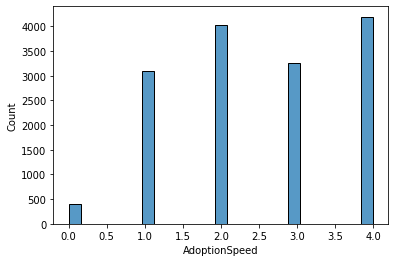

In [ ]:
sns.histplot(train_df['AdoptionSpeed'])
plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


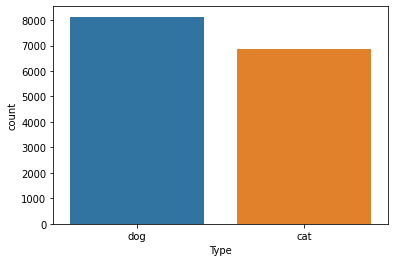

In [ ]:
ax = sns.countplot(train_df['Type'])
ax.set_xticklabels(['dog', 'cat'])
plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


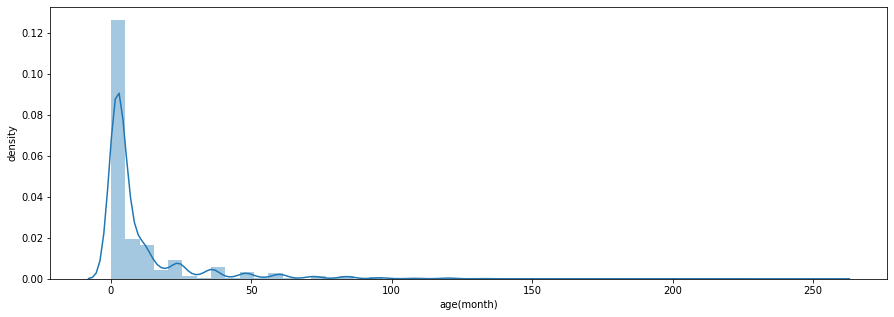

In [ ]:
plt.figure(figsize=(15,5))
ax = sns.distplot(train_df['Age'])
ax.set(xlabel='age(month)', ylabel='density')
plt.show()

#Preprocessing, train validation split

기본 structured 데이터만 이용(텍스트, 이미지등 제외)

In [ ]:
from sklearn.metrics import accuracy_score, mean_absolute_error, cohen_kappa_score

여기서는 maturity size와 furlength, health를 continuous feature로 봤음.

이유:
데이터셋에서는
예를들어 FurLength 의 경우 (1 = Short, 2 = Medium, 3 = Long, 0 = Not Specified) 로 categorical feature로 정의하지만 실제로 0(not specified)인 sample이 없으므로

이러한 경우 장점은 모델이 더 simple해짐(ocam's razor의 관점)



In [ ]:
#util functions 

def score(y_pred, y_true, metrics=[accuracy_score, mean_absolute_error, lambda x,y: cohen_kappa_score(x,y,weights='quadratic')], metrics_name = ['acc', 'mae', 'cohen\'s kappa']):
    output_dict = {}
    for m,name in zip(metrics, metrics_name):
        output_dict[name] = m(y_true, y_pred)
    return output_dict

#regression model의 prediction을 실제 예측치로 변환
def round_prediction(pred):
    pred = np.round(pred)
    pred = np.clip(pred, 0, 4)
    return pred

def to_normalize(pred):
    return pred / 4.

def from_normalize(pred):
    return pred * 4

#summarizing util
def summary(model, X_train=None, y_train=None, X_test=None, y_test=None, pred_decode_fn=None, true_decode_fn=None,train_acc=None,test_acc=None,comment=''):
    if pred_decode_fn is None:
        pred_decode_fn = lambda x:x
    if true_decode_fn is None:
        true_decode_fn = lambda x:x
    if comment:
        print(comment)
    else:
        try:
            if train_acc is None: print(model.__class__.__name__)
        except:
            pass
    if X_train is not None:
        train_score = score(pred_decode_fn(model.predict(X_train)), true_decode_fn(y_train))
        if train_acc is None: print('===train result===')
        for x,y in list(train_score.items()):
            if train_acc is not None : 
              train_acc[x].append(y)
            else: print(f'{x}:{y:.4f}')
    else:
        train_score = None
    if X_test is not None:
        test_score = score(pred_decode_fn(model.predict(X_test)), true_decode_fn(y_test))
        if test_acc is None: print('===valid result===')
        for x,y in list(test_score.items()):
            if test_acc is not None : 
              test_acc[x].append(y)          
            else: print(f'{x}:{y:.4f}')
        print()
    else:
        test_score = None

In [ ]:
print((train_df['FurLength'] == 0).sum())
print((train_df['MaturitySize'] == 0).sum())
print((train_df['Health'] == 0).sum())

0
0
0


In [ ]:
features = ['Type', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
            'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
            'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 'VideoAmt', 'PhotoAmt']

ord_features = ['MaturitySize', 'FurLength', 'Health']

cat_features = ['Type', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2', 'Color3',
                'Vaccinated', 'Dewormed', 'Sterilized', 'State']
                
con_features = ['Age', 'Quantity', 'Fee', 'VideoAmt', 'PhotoAmt']
target = 'AdoptionSpeed'

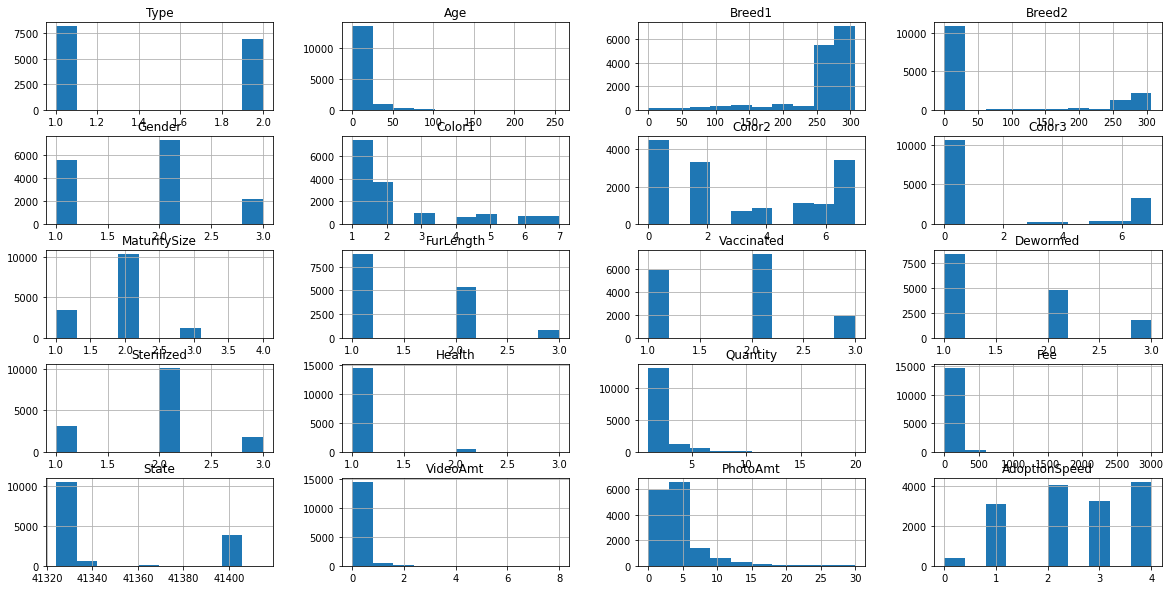

In [ ]:
train_df[features+[target]].hist(figsize=(20,10))
plt.show()

전처리:

연속형변수:standardization
범주형변수:one-hot encoding
순서형변수:ordinal encoding

특별한 경우가 아니면 계속해서 사전처리된 데이터 사용

In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
#유동적인 모델링 및 해석을 위해(변수 이름 같이 제공하기 위해) sklearn pipeline 사용안함.
def preprocess_input(X_train, X_test, features_to_standardize=None, features_to_onehot=None, return_onehot_names=False):
    if features_to_standardize is not None:
        #필요시 연속형 변수 standardization
        sc = StandardScaler()
        sc.fit(X_train[features_to_standardize])
        X_train.loc[:,features_to_standardize] = sc.transform(X_train[features_to_standardize])
        X_test.loc[:,features_to_standardize] = sc.transform(X_test[features_to_standardize])

    if features_to_onehot is not None:
        #필요시 범주형 변수 one-hot encoding
        #one-hot encoding은 train과 test를 합쳐서 transform해야함
        all = pd.concat([X_train, X_test])
        enc = OneHotEncoder()
        enc.fit(all[features_to_onehot])
        onehot_names = enc.get_feature_names_out()
        all[onehot_names] = enc.transform(all[features_to_onehot]).toarray()
        all = all.drop(features_to_onehot, axis=1) #원래 범주형 변수 버림
        X_train = all.iloc[:len(X_train)]
        X_test = all.iloc[len(X_train):]
    else:
        onehot_names = None
    
    if return_onehot_names:
        return X_train, X_test, onehot_names
    else:
        return X_train, X_test

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_df[features], train_df[target], test_size=0.3, random_state=SEED, stratify=train_df[target])
X_train, X_test, onehot_features = preprocess_input(X_train, X_test, features_to_standardize=con_features+ord_features, features_to_onehot=cat_features, return_onehot_names=True)
X_train.head()

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)


,Age,MaturitySize,FurLength,Health,Quantity,Fee,VideoAmt,PhotoAmt,Type_1,Type_2,...,State_41330,State_41332,State_41335,State_41336,State_41342,State_41345,State_41361,State_41367,State_41401,State_41415
13705,-0.520364,-1.579988,-0.771743,-0.186135,-0.392353,-0.278584,-0.168568,0.023997,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11009,-0.466171,0.250858,-0.771743,-0.186135,-0.392353,-0.278584,-0.168568,-0.259613,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10667,-0.520364,0.250858,-0.771743,-0.186135,0.299705,-0.278584,-0.168568,-0.259613,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
12991,-0.520364,0.250858,0.904467,-0.186135,0.299705,-0.278584,-0.168568,-0.826833,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6076,-0.520364,0.250858,-0.771743,-0.186135,3.759999,-0.010796,-0.168568,-0.826833,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Linear regression, classification

## Simple linear regression

In [ ]:
from sklearn.linear_model import LinearRegression, LogisticRegression 
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
from sklearn.decomposition import PCA,KernelPCA
from sklearn.decomposition import TruncatedSVD as SVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import MDS, TSNE, Isomap
from sklearn.manifold import LocallyLinearEmbedding as LLE

def dim_reduction(X_train, X_test, y_train=None, method='SVD', n_components=3,  **kwargs):
    if X_train is None:
        raise ValueError
    if method not in ['PCA', 'KernelPCA', 'SVD', 'LDA', 'MDS', 'LLE', 'Isomap', 'TSNE']:
        raise NotImplementedError

    model = eval(method)(n_components=n_components, **kwargs) #kwargs로 모델별 키워드 줄수있음
    if y_train is None:
        X_train_emb = model.fit_transform(X_train)
    else: #LDA
        X_train_emb = model.fit_transform(X_train, y_train)
    X_test_emb = model.transform(X_test)

    X_train_emb = pd.DataFrame(X_train_emb, columns = [f'{method}_component{i}' for i in range(n_components)], index=X_train.index)
    X_test_emb = pd.DataFrame(X_test_emb, columns = [f'{method}_component{i}' for i in range(n_components)], index=X_test.index)
    return X_train_emb, X_test_emb, model

def add_polynomial_features(train, test, degree=4, features=con_features):
    poly = PolynomialFeatures(degree=degree,include_bias=False)
    poly.fit(train[features])
    train_poly = train.copy()
    test_poly = test.copy()
    poly_names = poly.get_feature_names()
    train_poly_transform = poly.transform(train[features])
    test_poly_transform = poly.transform(test[features])
    num_poly_features = train_poly_transform.shape[-1]

    print(f'{num_poly_features} polynomial features added')
    for i in range(num_poly_features):
        name = poly_names[i]
        for j in range(len(features)):
            name = name.replace(f'x{j}', features[j])
        train_poly[name] = train_poly_transform[...,i]
        test_poly[name] = test_poly_transform[...,i]
    return train_poly, test_poly

# Nonparametric models: Kneighbors regression/classification, Kernel regression

#K-neighbors regression/classification 

In [ ]:
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

In [ ]:
#KNN은 preprocessnig에 따라 성능 달라질 수 있음(샘플간 거리가 달라지므로)
#standardization 안할때 성능이 훨씬 좋았음. 즉 각 feature의 scale이 의미있음
X_train, X_test, y_train, y_test = train_test_split(train_df[features], train_df[target], test_size=0.3, random_state=SEED, stratify=train_df[target])
X_train, X_test, onehot_features = preprocess_input(X_train, X_test, features_to_standardize=None, features_to_onehot=cat_features, return_onehot_names=True)
X_train.head()

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)


,Age,MaturitySize,FurLength,Health,Quantity,Fee,VideoAmt,PhotoAmt,Type_1,Type_2,...,State_41330,State_41332,State_41335,State_41336,State_41342,State_41345,State_41361,State_41367,State_41401,State_41415
13705,1,1,1,1,1,0,0,4.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11009,2,2,1,1,1,0,0,3.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10667,1,2,1,1,2,0,0,3.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
12991,1,2,2,1,2,0,0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6076,1,2,1,1,7,20,0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


마찬가지로 범주형/연속형 변수가 섞여있는 것을 주의해야한다.
범주형 변수에 euclidean distance는 별로 좋은 distance metric이 아닐 수 있다.

##K-Neighbors에 따른 성능비교, plot및 해석

In [ ]:
#n_neighbors에 민감함
model = KNeighborsClassifier(n_neighbors=20)
model.fit(X_train, y_train)
summary(model, X_train, y_train, X_test, y_test)

KNeighborsClassifier
===train result===
acc:0.4405
mae:0.9317
cohen's kappa:0.3114
===valid result===
acc:0.3526
mae:1.0545
cohen's kappa:0.2412



In [ ]:
model = KNeighborsRegressor(n_neighbors=10)
model.fit(X_train, y_train)
summary(model, X_train, y_train, X_test, y_test, round_prediction)

KNeighborsRegressor
===train result===
acc:0.3168
mae:0.8404
cohen's kappa:0.3283
===valid result===
acc:0.2835
mae:0.9277
cohen's kappa:0.2136



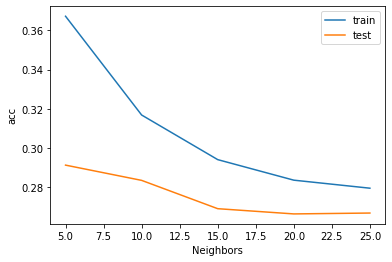

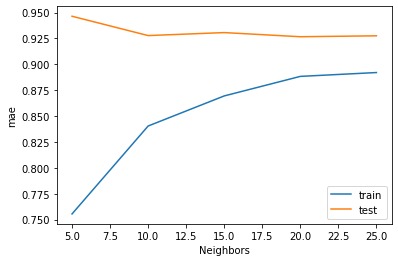

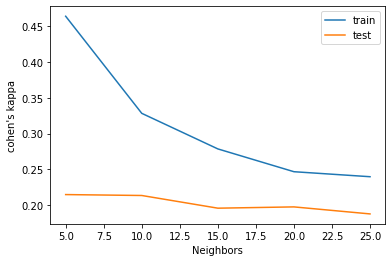

In [ ]:
indx = []
test_acc = {'acc':[],'mae':[],"cohen's kappa":[] }
train_acc = {'acc':[],'mae':[],"cohen's kappa":[] }
for i in range(5):
  indx.append((i+1)*5)
  model = KNeighborsRegressor(n_neighbors = (i+1)*5)
  model.fit(X_train,y_train)
  summary(model, X_train, y_train, X_test, y_test,round_prediction,train_acc = train_acc,test_acc=test_acc)
for x in train_acc.keys():
  plt.plot(indx,train_acc[x],label="train")
  plt.plot(indx,test_acc[x],label="test")
  plt.xlabel('Neighbors')
  plt.ylabel(x)
  plt.legend(loc='best')
  plt.show()

Neighbors 수는 10이 제일 좋은 모델이다. Neighbor수를 늘릴수록 Validation error의 변동은 적지만, training error이 늘어나므로 KNN model 사용시 Neighbor의 수가 10일 때 Test Error하고 Validation Error의 간극을 최소화가 된다.

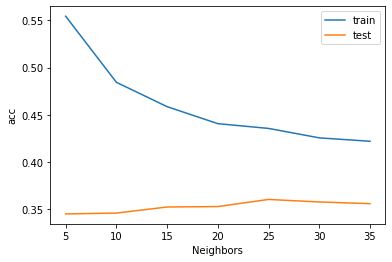

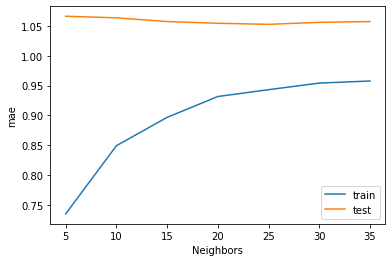

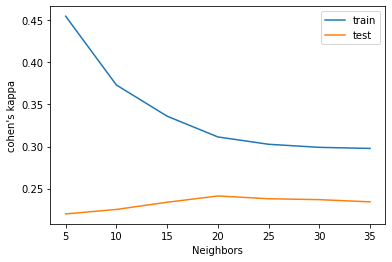

In [ ]:
indx = []
test_acc = {'acc':[],'mae':[],"cohen's kappa":[] }
train_acc = {'acc':[],'mae':[],"cohen's kappa":[] }
for i in range(7):
  indx.append((i+1)*5)
  model = KNeighborsClassifier(n_neighbors = (i+1)*5)
  model.fit(X_train,y_train)
  summary(model, X_train, y_train, X_test, y_test,round_prediction,train_acc = train_acc,test_acc=test_acc)
for x in train_acc.keys():
  plt.plot(indx,train_acc[x],label="train")
  plt.plot(indx,test_acc[x],label="test")
  plt.xlabel('Neighbors')
  plt.ylabel(x)
  plt.legend(loc='best')
  plt.show()

 Neighbor수에 대한 Validation error의 변동이 작으며 아주 느리게 감소하다 다시 증가한다. Neighbor수에 대해 test accuracy가 증가하다 감소하는 경향을 보인다. 이에 따라 k=20에서 cohen's kappa 기준으로 최적의 성능을 보인다.

범주형 변수의 거리 문제를 해결하기 위해 LDA를 사용가능하다.
추가로 LDA 사용시 feature dimension이 감소하므로 KNN의 속도가 향상된다.
다만 아래의 모델은 단순히 LDA에 의해 결정되는 것일 수도 있다.
참고) LDA + regression 또는 LDA만을 썼을 때보다는 아주 약간의 성능향상이 있음.

In [ ]:
X_train_lda, X_test_lda, lda = dim_reduction(X_train, X_test, y_train, method='LDA', n_components=4)
model = KNeighborsClassifier(n_neighbors=30)
model.fit(X_train_lda, y_train)
summary(model, X_train_lda, y_train, X_test_lda, y_test, round_prediction)

KNeighborsClassifier
===train result===
acc:0.4470
mae:0.8987
cohen's kappa:0.3641
===valid result===
acc:0.3497
mae:1.0491
cohen's kappa:0.2587



#Decision tree

In [ ]:
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

## Max-depth에 따른 성능비교, plot및 해석

In [ ]:
#decision tree의 경우 preprocessing 유무에 따라 성능이 변하지 않음. 더 쉬운 해석을 위해 안함.
X_train, X_test, y_train, y_test = train_test_split(train_df[features], train_df[target], test_size=0.3, random_state=SEED, stratify=train_df[target])
X_train, X_test, onehot_features = preprocess_input(X_train, X_test, features_to_standardize=None, features_to_onehot=cat_features, return_onehot_names=True)
X_train.head()

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)


,Age,MaturitySize,FurLength,Health,Quantity,Fee,VideoAmt,PhotoAmt,Type_1,Type_2,...,State_41330,State_41332,State_41335,State_41336,State_41342,State_41345,State_41361,State_41367,State_41401,State_41415
13705,1,1,1,1,1,0,0,4.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11009,2,2,1,1,1,0,0,3.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10667,1,2,1,1,2,0,0,3.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
12991,1,2,2,1,2,0,0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6076,1,2,1,1,7,20,0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
model = DecisionTreeClassifier(max_depth=5)
model.fit(X_train, y_train)
summary(model, X_train, y_train, X_test, y_test)

DecisionTreeClassifier
===train result===
acc:0.3897
mae:0.9951
cohen's kappa:0.3267
===valid result===
acc:0.3762
mae:1.0171
cohen's kappa:0.3143



예상했듯이 feature간의 비선형 관계를 설명할 수 있는 nonparametric한 decision tree 모델의 성능이 지금까지 고려했던 모든 모델들 보다 좋다.

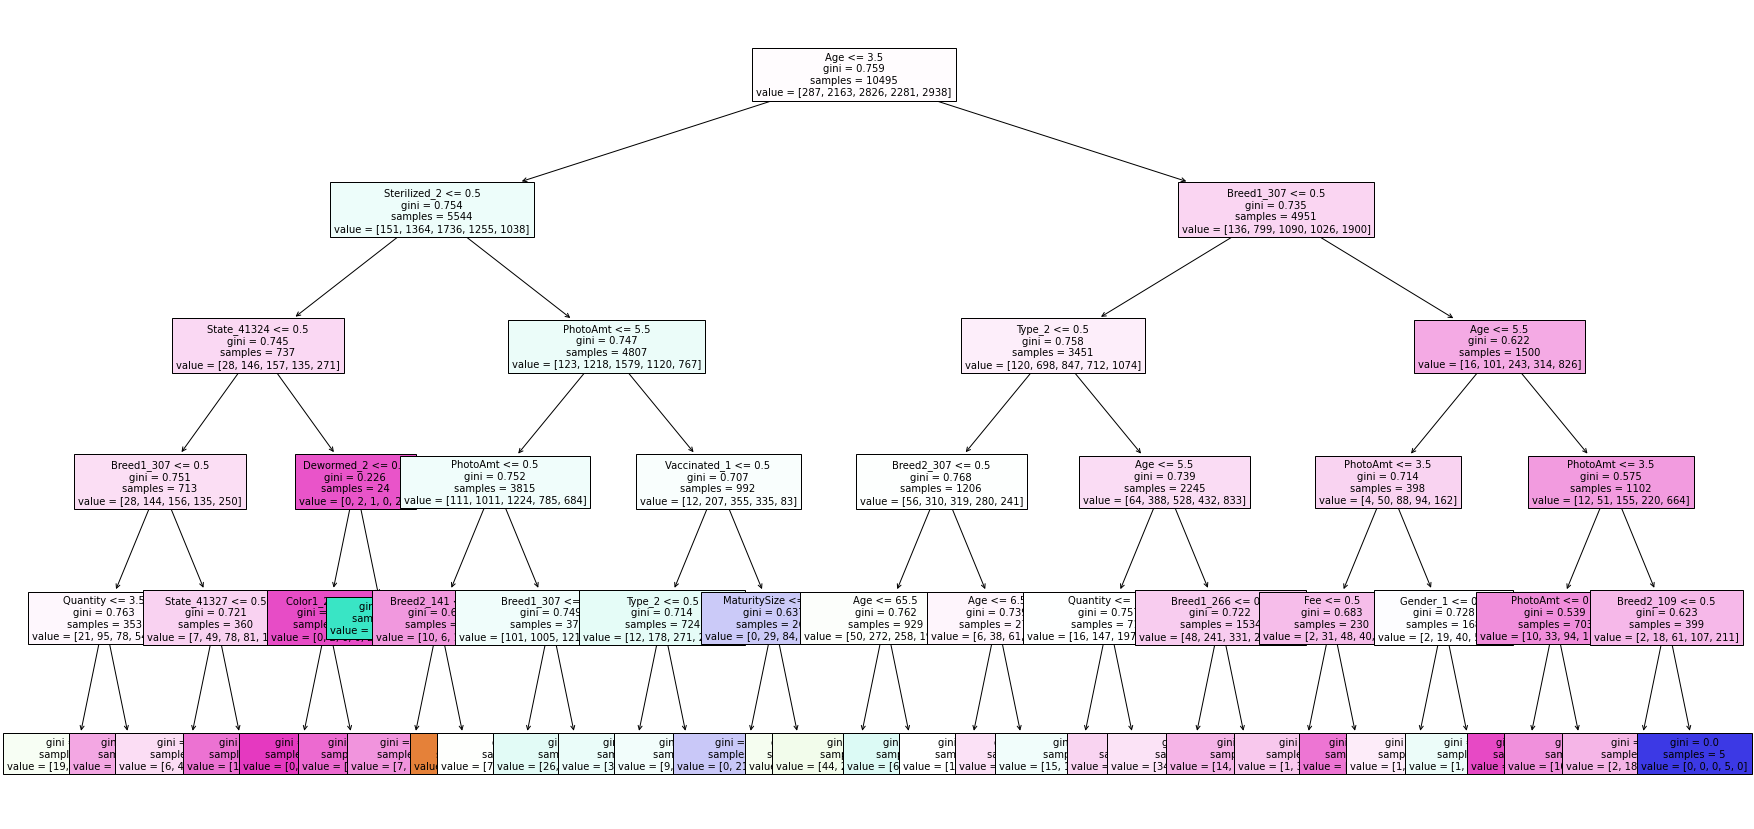

In [ ]:
plt.figure(figsize=(30,15))
sklearn.tree.plot_tree(model, filled=True, fontsize=10, feature_names=X_train.columns)
plt.show()

In [ ]:
model = DecisionTreeRegressor(max_depth=10)
model.fit(X_train, y_train)
summary(model, X_train, y_train, X_test, y_test, round_prediction)

DecisionTreeRegressor
===train result===
acc:0.3718
mae:0.7501
cohen's kappa:0.4697
===valid result===
acc:0.3115
mae:0.8975
cohen's kappa:0.2700



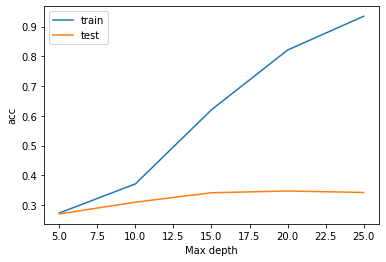

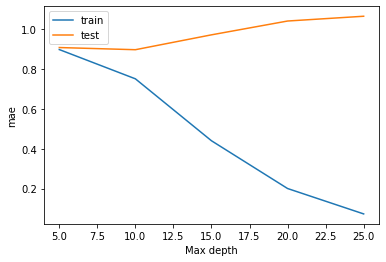

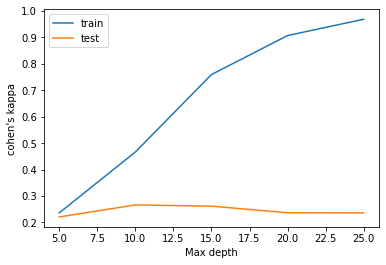

In [ ]:
indx = []
test_acc = {'acc':[],'mae':[],"cohen's kappa":[] }
train_acc = {'acc':[],'mae':[],"cohen's kappa":[] }
for i in range(5):
  indx.append((i+1)*5)
  model = DecisionTreeRegressor(max_depth=(i+1)*5)
  model.fit(X_train,y_train)
  summary(model, X_train, y_train, X_test, y_test,round_prediction,train_acc = train_acc,test_acc=test_acc)
for x in train_acc.keys():
  plt.plot(indx,train_acc[x],label="train")
  plt.plot(indx,test_acc[x],label="test")
  plt.xlabel('Max depth')
  plt.ylabel(x)
  plt.legend(loc='best')
  plt.show()

Max Depth 한도는 10에서 15사이로 두는게 적합하다.전반적으로 test accuracy의 변동이 적고, train accuracy는 계속 증가하지만, test accuracy는 max depth가 증가할수록 미세하게 줄어든다.

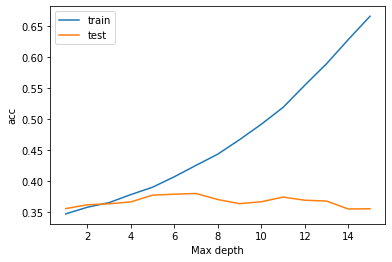

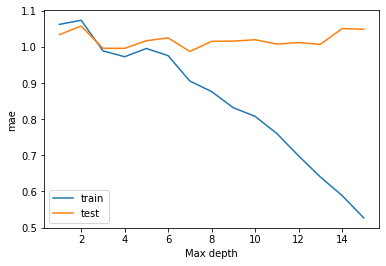

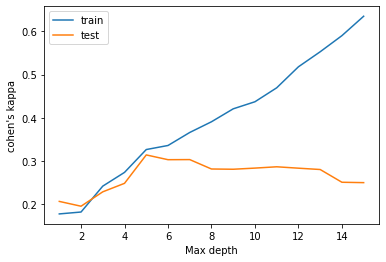

In [ ]:
indx = []
test_acc = {'acc':[],'mae':[],"cohen's kappa":[] }
train_acc = {'acc':[],'mae':[],"cohen's kappa":[] }
for i in range(15):
  indx.append(i+1)
  model = DecisionTreeClassifier(max_depth=(i+1))
  model.fit(X_train,y_train)
  summary(model, X_train, y_train, X_test, y_test,round_prediction,train_acc = train_acc,test_acc=test_acc)
for x in train_acc.keys():
  plt.plot(indx,train_acc[x],label="train")
  plt.plot(indx,test_acc[x],label="test")
  plt.xlabel('Max depth')
  plt.ylabel(x)
  plt.legend(loc='best')
  plt.show()

classifier의 최적 max_depth는 5 이다. max depth에 따라 MAE가 크게 변동하지는 않으나 증가할 수록 test error(MAE)가 감소하다가 3~5 인근에서 minima를 지난뒤 증가하는 경향을 보인다. test accuracy또한 크게 변화하지 않으나 증가하다가 감소하는 경향을 보인다. cohen's kappa가 최댓값인 max_depth=5가 최적인 것으로 보이며 이 이상으로 큰 tree는 과적합을 겪는것으로 보인다.

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/utils

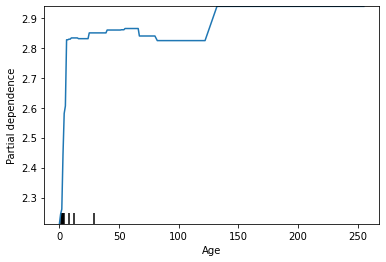

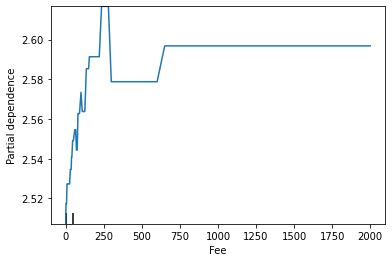

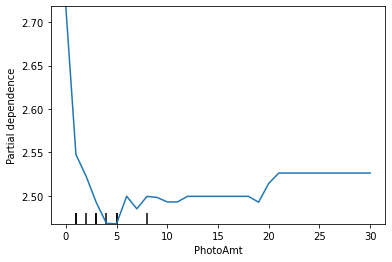

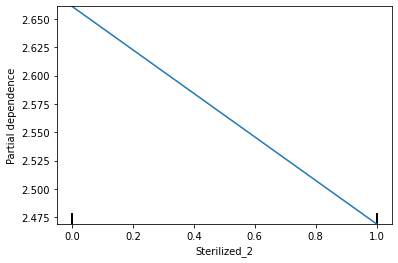

In [ ]:
#다른 변수들을 고정시킨 상태에서 하나의 특성변수의 증가에 따른 목표변수의 변화를 살펴봄. = 변수 영향력
from sklearn.inspection import plot_partial_dependence
fig1=plot_partial_dependence(model, X_train, features=['Age'])
fig2=plot_partial_dependence(model, X_train, features=['Fee'])
fig3=plot_partial_dependence(model, X_train, features=['PhotoAmt'])
fig4=plot_partial_dependence(model, X_train, features=['Sterilized_2'])

위 플롯을 통해 decision tree의 nonlinearity 특성을 확인이 가능하다.




#Kernel Regression/Classification

In [ ]:
from sklearn.svm import SVC, SVR

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_df[features], train_df[target], test_size=0.3, random_state=SEED, stratify=train_df[target])
X_train, X_test, onehot_features = preprocess_input(X_train, X_test, features_to_standardize=con_features, features_to_onehot=cat_features, return_onehot_names=True)
X_train.head()

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)


,Age,MaturitySize,FurLength,Health,Quantity,Fee,VideoAmt,PhotoAmt,Type_1,Type_2,...,State_41330,State_41332,State_41335,State_41336,State_41342,State_41345,State_41361,State_41367,State_41401,State_41415
13705,-0.520364,1,1,1,-0.392353,-0.278584,-0.168568,0.023997,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11009,-0.466171,2,1,1,-0.392353,-0.278584,-0.168568,-0.259613,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10667,-0.520364,2,1,1,0.299705,-0.278584,-0.168568,-0.259613,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
12991,-0.520364,2,2,1,0.299705,-0.278584,-0.168568,-0.826833,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6076,-0.520364,2,1,1,3.759999,-0.010796,-0.168568,-0.826833,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#SVM은 sample size에따라 computation time이 quadratic하게 증가. kernel에 따라 10000개에는 1시간까지도 걸림
#따라서 hyperparameter 조정을 위해서는 약 25% (2500개) 만 사용함
#참고)X_train은 사전에 shuffle 되어있음.
X_train_small = X_train[:2500]
y_train_small = y_train[:2500]

In [ ]:
#linear SVM
model = SVC(kernel='linear')
model.fit(X_train_small, y_train_small)
summary(model, X_train_small, y_train_small, X_test, y_test)

model = SVR(kernel='linear')
model.fit(X_train_small, y_train_small)
summary(model, X_train_small, y_train_small, X_test, y_test, round_prediction)

SVC
===train result===
acc:0.4440
mae:0.8752
cohen's kappa:0.3695
===valid result===
acc:0.3415
mae:1.0607
cohen's kappa:0.2206

SVR
===train result===
acc:0.3556
mae:0.8268
cohen's kappa:0.3783
===valid result===
acc:0.2944
mae:0.9602
cohen's kappa:0.2188



In [ ]:
#SVM with polynomial kernel
model = SVC(kernel='poly', degree=3)
model.fit(X_train_small, y_train_small)
summary(model, X_train_small, y_train_small, X_test, y_test)

model = SVR(kernel='poly', degree=3)
model.fit(X_train_small, y_train_small)
summary(model, X_train_small, y_train_small, X_test, y_test, round_prediction)

SVC
===train result===
acc:0.5244
mae:0.7764
cohen's kappa:0.4472
===valid result===
acc:0.3586
mae:1.0474
cohen's kappa:0.2463

SVR
===train result===
acc:0.4308
mae:0.6996
cohen's kappa:0.4929
===valid result===
acc:0.3032
mae:0.9206
cohen's kappa:0.2410



In [ ]:
#SVM with gaussian kernel
model = SVC(kernel='rbf')
model.fit(X_train_small, y_train_small)
summary(model, X_train_small, y_train_small, X_test, y_test)

model = SVR(kernel='rbf')
model.fit(X_train_small, y_train_small)
summary(model, X_train_small, y_train_small, X_test, y_test, round_prediction)

SVC
===train result===
acc:0.4712
mae:0.8636
cohen's kappa:0.3877
===valid result===
acc:0.3573
mae:1.0498
cohen's kappa:0.2423

SVR
===train result===
acc:0.3912
mae:0.7524
cohen's kappa:0.4423
===valid result===
acc:0.3095
mae:0.9017
cohen's kappa:0.2582



In [ ]:
model = SVR(kernel='rbf', C=0.01)
model.fit(X_train_small, y_train_small)
summary(model, X_train_small, y_train_small, X_test, y_test, round_prediction)
print(f'# of support vectors {model.n_support_}')

model = SVR(kernel='rbf', C=0.05)
model.fit(X_train_small, y_train_small)
summary(model, X_train_small, y_train_small, X_test, y_test, round_prediction)
print(f'# of support vectors {model.n_support_}')

model = SVR(kernel='rbf', C=0.1)
model.fit(X_train_small, y_train_small)
summary(model, X_train_small, y_train_small, X_test, y_test, round_prediction)
print(f'# of support vectors {model.n_support_}')

model = SVR(kernel='rbf', C=0.5)
model.fit(X_train_small, y_train_small)
summary(model, X_train_small, y_train_small, X_test, y_test, round_prediction)
print(f'# of support vectors {model.n_support_}')

model = SVR(kernel='rbf', C=1)
model.fit(X_train_small, y_train_small)
summary(model, X_train_small, y_train_small, X_test, y_test, round_prediction)
print(f'# of support vectors {model.n_support_}')

model = SVR(kernel='rbf', C=5)
model.fit(X_train_small, y_train_small)
summary(model, X_train_small, y_train_small, X_test, y_test, round_prediction)
print(f'# of support vectors {model.n_support_}')

model = SVR(kernel='rbf', C=10)
model.fit(X_train_small, y_train_small)
summary(model, X_train_small, y_train_small, X_test, y_test, round_prediction)
print(f'# of support vectors {model.n_support_}')

SVR
===train result===
acc:0.2660
mae:0.9812
cohen's kappa:0.0996
===valid result===
acc:0.2721
mae:0.9902
cohen's kappa:0.0787

# of support vectors [2471]
SVR
===train result===
acc:0.2620
mae:0.9324
cohen's kappa:0.1850
===valid result===
acc:0.2695
mae:0.9422
cohen's kappa:0.1547

# of support vectors [2371]
SVR
===train result===
acc:0.2688
mae:0.9116
cohen's kappa:0.2226
===valid result===
acc:0.2766
mae:0.9297
cohen's kappa:0.1750

# of support vectors [2359]
SVR
===train result===
acc:0.3360
mae:0.8208
cohen's kappa:0.3611
===valid result===
acc:0.3001
mae:0.9068
cohen's kappa:0.2396

# of support vectors [2345]
SVR
===train result===
acc:0.3912
mae:0.7524
cohen's kappa:0.4423
===valid result===
acc:0.3095
mae:0.9017
cohen's kappa:0.2582

# of support vectors [2349]
SVR
===train result===
acc:0.5572
mae:0.5368
cohen's kappa:0.6537
===valid result===
acc:0.3150
mae:0.9213
cohen's kappa:0.2697

# of support vectors [2346]
SVR
===train result===
acc:0.6500
mae:0.4208
cohen's kappa

##C값, support vector개수 변화에 대한 성능비교 및 분석

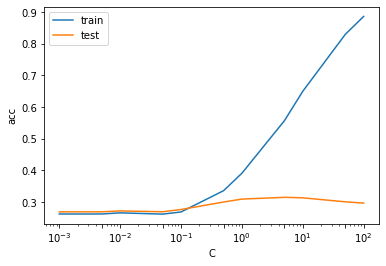

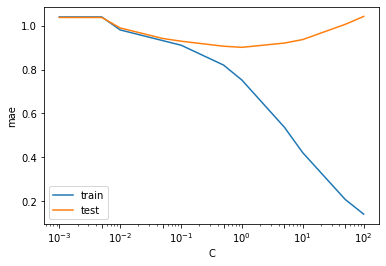

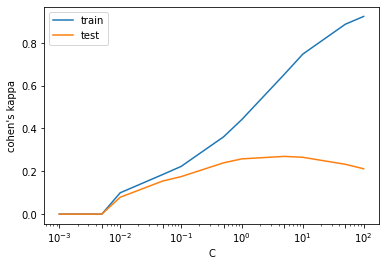

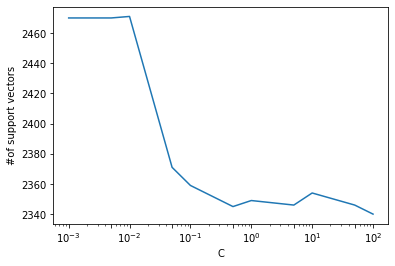

,C,train acc,test acc,train mae,test mae,train cohen's kappa,test cohen's kappa,n_support vectors
0,0.001,0.2624,0.269231,1.0404,1.038017,0.000000,0.000000,[2470]
1,0.005,0.2624,0.269231,1.0404,1.038017,0.000000,0.000000,[2470]
2,0.010,0.2660,0.272121,0.9812,0.990218,0.099569,0.078682,[2471]
3,0.050,0.2620,0.269453,0.9324,0.942197,0.184990,0.154664,[2371]
4,0.100,0.2688,0.276567,0.9116,0.929747,0.222628,0.175027,[2359]
5,0.500,0.3360,0.300133,0.8208,0.906847,0.361051,0.239555,[2345]
6,1.000,0.3912,0.309471,0.7524,0.901734,0.442307,0.258189,[2349]
7,5.000,0.5572,0.315029,0.5368,0.921298,0.653741,0.269728,[2346]
8,10.000,0.6500,0.313473,0.4208,0.937305,0.747352,0.265424,[2354]
9,50.000,0.8300,0.300800,0.2072,1.006892,0.887101,0.232772,[2346]


In [ ]:
#@title SVR rbf
test_acc = {'acc':[],'mae':[],"cohen's kappa":[]}
train_acc = {'acc':[],'mae':[],"cohen's kappa":[]}
n_supportVectors=[]
indx=[round(0.1**n,5) for n in range(-2,4)]
indx2=[i*5 for i in indx]
indx2.pop(0)
indx=indx2+indx
indx.sort()
for c in indx:
  model = SVR(kernel='rbf', C=c)
  model.fit(X_train_small,y_train_small)
  summary(model, X_train_small, y_train_small, X_test, y_test,round_prediction,train_acc = train_acc,test_acc=test_acc)
  n_supportVectors.append(model.n_support_)
for x in train_acc.keys():
  plt.plot(indx,train_acc[x],label="train")
  plt.plot(indx,test_acc[x],label="test")
  plt.xlabel('C')
  plt.xscale('log')
  plt.xticks(indx)
  plt.ylabel(x)
  plt.legend(loc='best')
  plt.show()
plt.plot(indx,n_supportVectors)
plt.xlabel('C')
plt.xscale('log')
plt.xticks(indx)
plt.ylabel("#of support vectors")
plt.show()
table=pd.DataFrame()
table["C"]=indx
for x in train_acc.keys():
  table[f"train {x}"]=train_acc[x]
  table[f"test {x}"]=test_acc[x]
table["n_support vectors"]=n_supportVectors
table

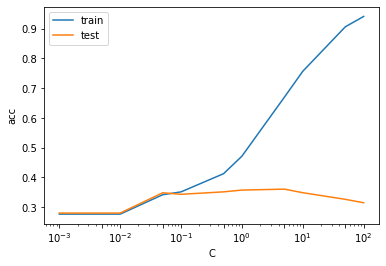

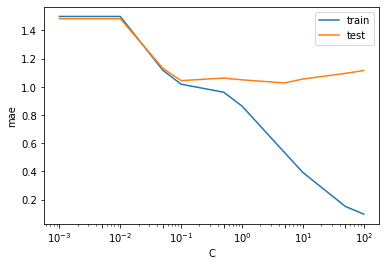

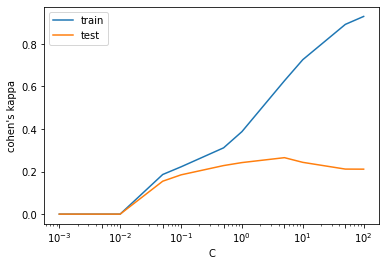

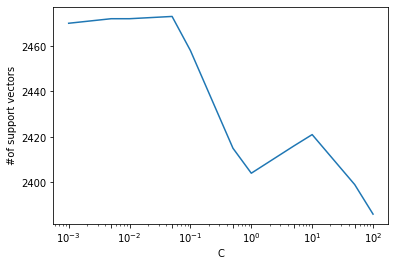

,C,train acc,test acc,train mae,test mae,train cohen's kappa,test cohen's kappa,n_support vectors
0,0.001,0.2764,0.279902,1.4996,1.483548,0.000000,0.000000,2470
1,0.005,0.2764,0.279902,1.4996,1.483548,0.000000,0.000000,2472
2,0.010,0.2764,0.279902,1.4996,1.483548,0.000000,0.000000,2472
3,0.050,0.3416,0.348155,1.1180,1.131836,0.186255,0.154690,2473
4,0.100,0.3512,0.343041,1.0188,1.044242,0.222297,0.184624,2458
5,0.500,0.4124,0.351267,0.9620,1.062472,0.311594,0.228224,2415
6,1.000,0.4712,0.357270,0.8636,1.049800,0.387691,0.242279,2404
7,5.000,0.6700,0.360382,0.5336,1.028012,0.627051,0.265401,2416
8,10.000,0.7568,0.348377,0.3924,1.055580,0.726086,0.243389,2421
9,50.000,0.9064,0.326145,0.1512,1.095820,0.892008,0.211688,2399


In [ ]:
#@title SVC rbf
test_acc = {'acc':[],'mae':[],"cohen's kappa":[]}
train_acc = {'acc':[],'mae':[],"cohen's kappa":[]}
n_supportVectors=[]
indx=[round(0.1**n,5) for n in range(-2,4)]
indx2=[i*5 for i in indx]
indx2.pop(0)
indx=indx2+indx
indx.sort()
for c in indx:
  model = SVC(kernel='rbf', C=c)
  model.fit(X_train_small,y_train_small)
  summary(model, X_train_small, y_train_small, X_test, y_test,round_prediction,train_acc = train_acc,test_acc=test_acc)
  n_supportVectors.append(model.n_support_)
for x in train_acc.keys():
  plt.plot(indx,train_acc[x],label="train")
  plt.plot(indx,test_acc[x],label="test")
  plt.xlabel('C')
  plt.xscale('log')
  plt.xticks(indx)
  plt.ylabel(x)
  plt.legend(loc='best')
  plt.show()
n_supportVectors=[sum(list(x)) for x in n_supportVectors]
plt.plot(indx,n_supportVectors)
plt.xlabel('C')
plt.xscale('log')
plt.xticks(indx)
plt.ylabel("#of support vectors")
plt.show()

table["C"]=indx
for x in train_acc.keys():
  table[f"train {x}"]=train_acc[x]
  table[f"test {x}"]=test_acc[x]
table["n_support vectors"]=n_supportVectors
table

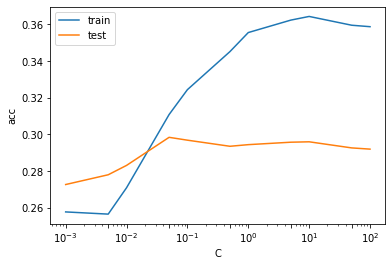

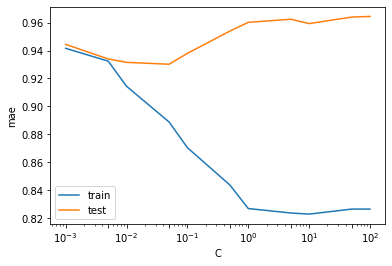

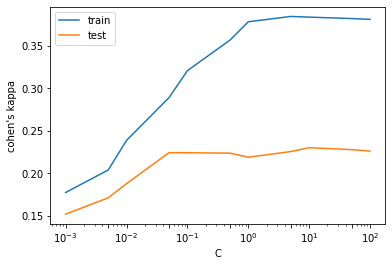

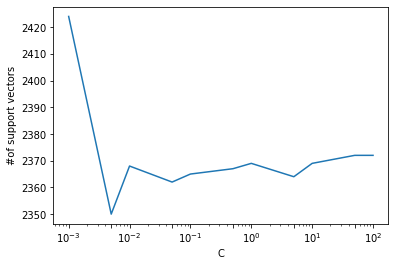

,C,train acc,test acc,train mae,test mae,train cohen's kappa,test cohen's kappa,n_support vectors
0,0.001,0.2576,0.272566,0.9416,0.944420,0.177314,0.151851,[2424]
1,0.005,0.2564,0.277901,0.9324,0.933971,0.203810,0.170996,[2350]
2,0.010,0.2708,0.283015,0.9144,0.931525,0.238681,0.187754,[2368]
3,0.050,0.3108,0.298355,0.8888,0.930191,0.289080,0.224239,[2362]
4,0.100,0.3244,0.296799,0.8704,0.937972,0.320745,0.224077,[2365]
5,0.500,0.3452,0.293464,0.8436,0.953980,0.356697,0.223640,[2367]
6,1.000,0.3556,0.294353,0.8268,0.960205,0.378333,0.218849,[2369]
7,5.000,0.3624,0.295687,0.8236,0.962428,0.384563,0.225502,[2364]
8,10.000,0.3644,0.295909,0.8228,0.959315,0.383765,0.230075,[2369]
9,50.000,0.3596,0.292574,0.8264,0.963984,0.382088,0.227773,[2372]


In [ ]:
#@title SVR linear
test_acc = {'acc':[],'mae':[],"cohen's kappa":[]}
train_acc = {'acc':[],'mae':[],"cohen's kappa":[]}
n_supportVectors=[]
indx=[round(0.1**n,5) for n in range(-2,4)]
indx2=[i*5 for i in indx]
indx2.pop(0)
indx=indx2+indx
indx.sort()
for c in indx:
  model = SVR(kernel='linear', C=c)
  model.fit(X_train_small,y_train_small)
  summary(model, X_train_small, y_train_small, X_test, y_test,round_prediction,train_acc = train_acc,test_acc=test_acc)
  n_supportVectors.append(model.n_support_)
for x in train_acc.keys():
  plt.plot(indx,train_acc[x],label="train")
  plt.plot(indx,test_acc[x],label="test")
  plt.xlabel('C')
  plt.xscale('log')
  plt.xticks(indx)
  plt.ylabel(x)
  plt.legend(loc='best')
  plt.show()
plt.plot(indx,n_supportVectors)
plt.xlabel('C')
plt.xscale('log')
plt.xticks(indx)
plt.ylabel("#of support vectors")
plt.show()

table["C"]=indx
for x in train_acc.keys():
  table[f"train {x}"]=train_acc[x]
  table[f"test {x}"]=test_acc[x]
table["n_support vectors"]=n_supportVectors
table

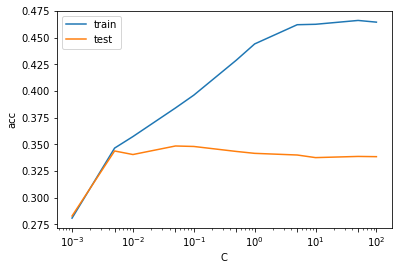

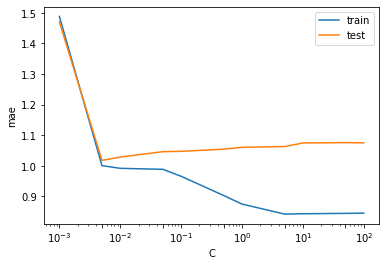

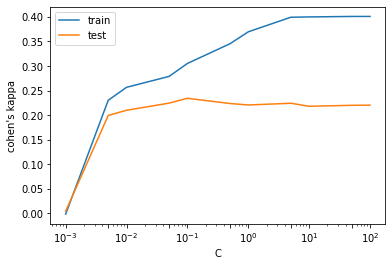

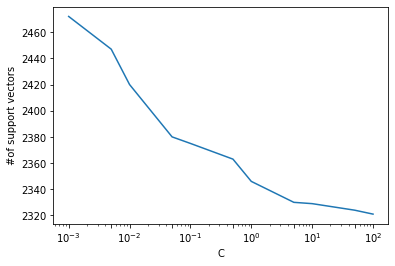

,C,train acc,test acc,train mae,test mae,train cohen's kappa,test cohen's kappa,n_support vectors
0,0.001,0.2808,0.282792,1.4884,1.470209,-0.001543,0.004252,2472
1,0.005,0.3464,0.343708,1.0008,1.018008,0.230173,0.199291,2447
2,0.010,0.3572,0.340373,0.9920,1.028902,0.256576,0.209854,2420
3,0.050,0.3840,0.348377,0.9888,1.046465,0.278800,0.224383,2380
4,0.100,0.3960,0.347932,0.9660,1.047577,0.305144,0.234254,2375
5,0.500,0.4288,0.343264,0.9032,1.054691,0.345266,0.223619,2363
6,1.000,0.4440,0.341485,0.8752,1.060694,0.369539,0.220592,2346
7,5.000,0.4620,0.339929,0.8424,1.063139,0.399218,0.224149,2330
8,10.000,0.4624,0.337483,0.8436,1.074922,0.399857,0.217957,2329
9,50.000,0.4660,0.338595,0.8448,1.076034,0.400841,0.219964,2324


In [ ]:
#@title SVC linear
test_acc = {'acc':[],'mae':[],"cohen's kappa":[]}
train_acc = {'acc':[],'mae':[],"cohen's kappa":[]}
n_supportVectors=[]
indx=[round(0.1**n,5) for n in range(-2,4)]
indx2=[i*5 for i in indx]
indx2.pop(0)
indx=indx2+indx
indx.sort()
for c in indx:
  model = SVC(kernel='linear', C=c)
  model.fit(X_train_small,y_train_small)
  summary(model, X_train_small, y_train_small, X_test, y_test,round_prediction,train_acc = train_acc,test_acc=test_acc)
  n_supportVectors.append(model.n_support_)
for x in train_acc.keys():
  plt.plot(indx,train_acc[x],label="train")
  plt.plot(indx,test_acc[x],label="test")
  plt.xlabel('C')
  plt.xscale('log')
  plt.xticks(indx)
  plt.ylabel(x)
  plt.legend(loc='best')
  plt.show()
n_supportVectors=[sum(list(x)) for x in n_supportVectors]
plt.plot(indx,n_supportVectors)
plt.xlabel('C')
plt.xscale('log')
plt.xticks(indx)
plt.ylabel("#of support vectors")
plt.show()

table["C"]=indx
for x in train_acc.keys():
  table[f"train {x}"]=train_acc[x]
  table[f"test {x}"]=test_acc[x]
table["n_support vectors"]=n_supportVectors
table

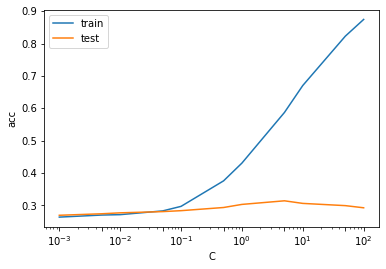

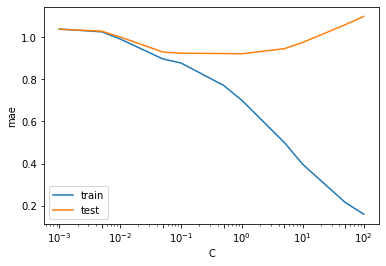

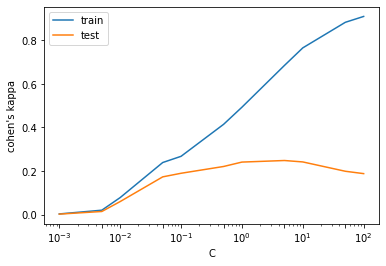

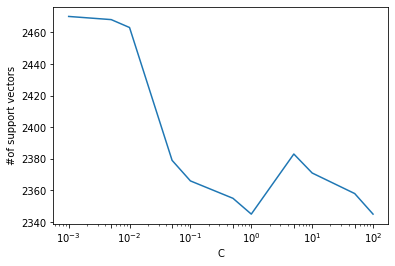

,C,train acc,test acc,train mae,test mae,train cohen's kappa,test cohen's kappa,n_support vectors
0,0.001,0.2640,0.269675,1.0380,1.037128,0.002914,0.002070,[2470]
1,0.005,0.2704,0.274344,1.0248,1.028012,0.020132,0.014144,[2468]
2,0.010,0.2716,0.277234,0.9908,1.000222,0.077975,0.059708,[2463]
3,0.050,0.2832,0.281014,0.8964,0.929302,0.238985,0.173143,[2379]
4,0.100,0.2972,0.283904,0.8768,0.923299,0.267493,0.189640,[2366]
5,0.500,0.3760,0.293686,0.7708,0.921965,0.414393,0.220808,[2355]
6,1.000,0.4308,0.303246,0.6996,0.920631,0.492948,0.241018,[2345]
7,5.000,0.5872,0.314362,0.4992,0.945087,0.684905,0.248242,[2383]
8,10.000,0.6704,0.306358,0.3960,0.974655,0.765482,0.241718,[2371]
9,50.000,0.8228,0.299466,0.2148,1.058693,0.882955,0.198864,[2358]


In [ ]:
#@title SVR poly
test_acc = {'acc':[],'mae':[],"cohen's kappa":[]}
train_acc = {'acc':[],'mae':[],"cohen's kappa":[]}
n_supportVectors=[]
indx=[round(0.1**n,5) for n in range(-2,4)]
indx2=[i*5 for i in indx]
indx2.pop(0)
indx=indx2+indx
indx.sort()
for c in indx:
  model = SVR(kernel='poly',degree=3, C=c)
  model.fit(X_train_small,y_train_small)
  summary(model, X_train_small, y_train_small, X_test, y_test,round_prediction,train_acc = train_acc,test_acc=test_acc)
  n_supportVectors.append(model.n_support_)
for x in train_acc.keys():
  plt.plot(indx,train_acc[x],label="train")
  plt.plot(indx,test_acc[x],label="test")
  plt.xlabel('C')
  plt.xscale('log')
  plt.xticks(indx)
  plt.ylabel(x)
  plt.legend(loc='best')
  plt.show()
plt.plot(indx,n_supportVectors)
plt.xlabel('C')
plt.xscale('log')
plt.xticks(indx)
plt.ylabel("#of support vectors")
plt.show()

table["C"]=indx
for x in train_acc.keys():
  table[f"train {x}"]=train_acc[x]
  table[f"test {x}"]=test_acc[x]
table["n_support vectors"]=n_supportVectors
table

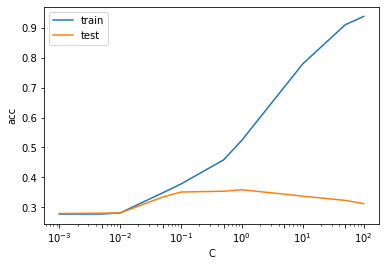

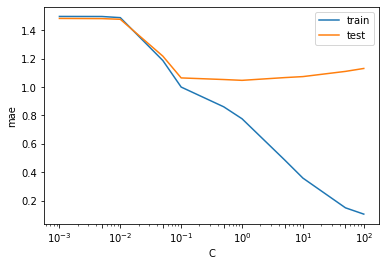

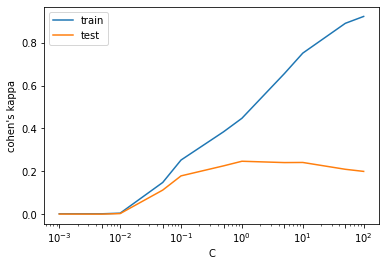

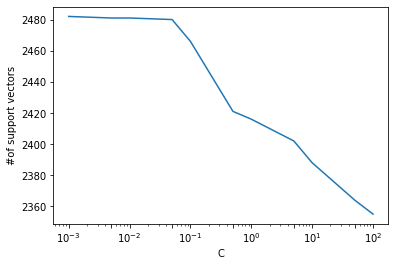

,C,train acc,test acc,train mae,test mae,train cohen's kappa,test cohen's kappa,n_support vectors
0,0.001,0.2772,0.279458,1.4980,1.483993,0.000659,-0.000724,2482
1,0.005,0.2776,0.280347,1.4976,1.482659,0.000550,-0.000957,2481
2,0.010,0.2812,0.281014,1.4896,1.477990,0.003417,0.001555,2481
3,0.050,0.3484,0.334149,1.1872,1.218097,0.147002,0.111364,2480
4,0.100,0.3780,0.351045,1.0000,1.064473,0.251948,0.177840,2466
5,0.500,0.4584,0.353713,0.8608,1.053135,0.384120,0.224747,2421
6,1.000,0.5244,0.358604,0.7764,1.047354,0.447168,0.246270,2416
7,5.000,0.7028,0.343931,0.4864,1.066696,0.656494,0.240042,2402
8,10.000,0.7796,0.337261,0.3580,1.073811,0.751858,0.240587,2388
9,50.000,0.9104,0.323032,0.1484,1.110494,0.891255,0.208659,2364


In [ ]:
#@title SVC poly
test_acc = {'acc':[],'mae':[],"cohen's kappa":[]}
train_acc = {'acc':[],'mae':[],"cohen's kappa":[]}
n_supportVectors=[]
indx=[round(0.1**n,5) for n in range(-2,4)]
indx2=[i*5 for i in indx]
indx2.pop(0)
indx=indx2+indx
indx.sort()
for c in indx:
  model = SVC(kernel='poly',degree=3, C=c)
  model.fit(X_train_small,y_train_small)
  summary(model, X_train_small, y_train_small, X_test, y_test,round_prediction,train_acc = train_acc,test_acc=test_acc)
  n_supportVectors.append(model.n_support_)
for x in train_acc.keys():
  plt.plot(indx,train_acc[x],label="train")
  plt.plot(indx,test_acc[x],label="test")
  plt.xlabel('C')
  plt.xscale('log')
  plt.xticks(indx)
  plt.ylabel(x)
  plt.legend(loc='best')
  plt.show()
n_supportVectors=[sum(list(x)) for x in n_supportVectors]
plt.plot(indx,n_supportVectors)
plt.xlabel('C')
plt.xscale('log')
plt.xticks(indx)
plt.ylabel("#of support vectors")
plt.show()

table["C"]=indx
for x in train_acc.keys():
  table[f"train {x}"]=train_acc[x]
  table[f"test {x}"]=test_acc[x]
table["n_support vectors"]=n_supportVectors
table

### 결과해석
RBF커널, C=5, regression일 때 cohen's kappa가 0.269728로 가장 높았다, 대부분의 모델에서 C=1~5 일때 최적의 성능을 보였다. C가 커질수록 test accuracy는 증가하다 감소하고 test mean absolute arror는 감소하가다 증가하는 경향을 보인다. 
C가 매우 작을 경우 성능이 매우 떨어지며 이는 support vector수가 빠르게 감소하는 것으로 볼 때 너무 많은 soft error를 허용했기 때문으로 보인다. C가 커지는 경우 학습 데이터에 매우 충실하여 variance가 높아져 성능이 감소하는 것을 확인할 수 있다.

In [ ]:
#@markdown 전체 training set 사용시 cohen's kappa 0.3269로 준수한 성능 보임
#오래걸림
model = SVR(kernel='rbf', C=5)
model.fit(X_train, y_train)
summary(model, X_train, y_train, X_test, y_test, round_prediction)
print(f'# of support vectors {model.n_support_}')

SVR
===train result===
acc:0.4959
mae:0.6249
cohen's kappa:0.5667
===valid result===
acc:0.3299
mae:0.8775
cohen's kappa:0.3269

# of support vectors [9766]


#PART2: DEEP LEARNING

가설 세웠던 대로, nonparametric 모델들이 feature와 target간의 nonlinear relation을 더 잘 설명했고, 더 좋은 성능을 보였음을 확인이 된다. 특히 SVM과 CART는 midterm 때 고려했던 parametric 모델들에 비해 월등히 좋은 성능을 보였다.

그러나 아직 성능이 만족할 만한 성능을 보여주지 못한다. -> feature engineering(feature 고안, metadata 추가등)으로 해결해야함
그러나 SVM과 CART는 feature engineering에 제약을 가짐.
SVM) feature가 늘어날수록 안그래도 느린데 더느려진다. (Increases quadratically) 
CART) greedy 하게 단일 feature들의 영향력을 고려하는 알고리즘이므로, feature를 추가할 때마다 성능이 크게 달라진다. (ex. 나쁜 feature를 추가할 경우, overfitting이 발생할 가능성이 높아진다)

해결방법은 PCA나 feature selection등을 이용하는 것이지만 이또한 feature를 엄청나게 많이 추가할 경우(metadata) 잘 작동하지 않는다(실제 구현에서도 잘 안됐다).

한편 딥러닝 모델은 추가된 feature들을 모델이 알아서 feature extraction하기 때문에, 상대로적으로 이러한 제약에서 자유로움(feature 마구잡이로 넣어도 어느정도 잘 작동한다). + feature 간 nonlinear relationship을 여러 층의 hidden layer와 비선형 활성함수들을 통해 잡아낼 수 있다. 따라서 MLP부터 시작하여 딥러닝 모델을 고려한다.

# MLP

In [ ]:
def preprocess_img(path, img_size=224, augment=False):
    #if path is list, select one if exists, else return empty image
    def parse_list(path_list, augment):
        path_list = tf.cond(tf.size(path_list)==0, lambda:tf.convert_to_tensor(['train_images/empty.jpg']), lambda:path_list)
        if augment:
            path = tf.random.shuffle(path_list)[0]
        else:
            path = path_list[0]
        return path
    path = tf.cond(tf.rank(path)>0, lambda: parse_list(path,augment), lambda:path)
    contents = tf.io.read_file(path)
    img = tf.io.decode_image(contents, channels=3, expand_animations = False)
    img = tf.image.resize(img, (img_size, img_size), 'bicubic')
    if augment:
        img = tf.image.random_flip_left_right(img)
    img = tf.cast(img, tf.float32)/255.
    return img

def tf_encode_onehot(y):
    return tf.one_hot(y, 5)

def tf_decode_onehot(y):
    return tf.argmax(y, axis=-1)

def tf_encode_ordinal(y, depth=4):
    y = tf.clip_by_value(y, 0, depth)
    return tf.convert_to_tensor([x < y for x in range(depth)], dtype = tf.float32)

def decode_ordinal(y, depth=4):
    return round_prediction(np.sum(y, axis=-1))

def get_ds(X, y, img_path=None, img_size=224, txt=None, tokenizer=None, encode_y_fn=None, batch_size=16, augment=False, repeat=False, shuffle=False):
    y_ds = tf.data.Dataset.from_tensor_slices(y)
    if encode_y_fn is not None:
        y_ds = y_ds.map(encode_y_fn, tf.data.AUTOTUNE)
        
    x_ds = []
    if X is not None:
        x_ds.append(tf.data.Dataset.from_tensor_slices(X))
    if img_path is not None:
        ds = tf.data.Dataset.from_tensor_slices(img_path)
        ds = ds.map(lambda x:preprocess_img(x, img_size=img_size, augment=augment), tf.data.AUTOTUNE)
        x_ds.append(ds)
    if txt is not None:
        ds = tf.data.Dataset.from_tensor_slices(txt)
        if tokenizer is not None:
            ds = ds.map(lambda x:tokenizer(x), tf.data.AUTOTUNE)
        x_ds.append(ds)
    x_ds = tuple(x_ds)
    
    if len(x_ds)==1:
        x_ds = x_ds[0]
    elif len(x_ds)==0:
        raise ValueError
    
    ds = tf.data.Dataset.zip((x_ds,y_ds))

    if repeat: 
        ds = ds.repeat()
        
    if shuffle:
        ds = ds.shuffle(2048, seed=SEED)
        options = tf.data.Options()
        options.experimental_deterministic = (False)
        ds = ds.with_options(options)
    
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
        
    return ds

In [ ]:
def mlp_module(input_dim, hidden_sizes, hidden_activation='relu', head_dim=None, head_activation=None):
    inp = tf.keras.Input((input_dim,))
    x = inp
    for d in hidden_sizes:
        x = tf.keras.layers.Dense(d,activation=hidden_activation)(x)
    if head_dim is not None:
        x = tf.keras.layers.Dense(head_dim,activation=head_activation)(x)
    return tf.keras.Model(inp, x)

MLP(softmax)

In [ ]:
tf.keras.backend.clear_session()

epochs = 7
batch_size = 32
lr = 2e-3
weight_decay = 1e-2


X_train, X_test, y_train, y_test = train_test_split(train_df[features], train_df[target], test_size=0.3, random_state=SEED, stratify=train_df[target])
X_train, X_test, onehot_features = preprocess_input(X_train, X_test, features_to_standardize=con_features, features_to_onehot=cat_features, return_onehot_names=True)
train_ds = get_ds(X_train, y_train, batch_size=batch_size, repeat=True, shuffle=True, encode_y_fn=tf_encode_onehot)
valid_ds = get_ds(X_test, y_test, batch_size=batch_size, repeat=False, shuffle=False, encode_y_fn=tf_encode_onehot)

steps_per_epoch = len(X_train)//batch_size
total_steps = steps_per_epoch*epochs

model = mlp_module(len(X_train.columns), hidden_sizes=(128,512,128), hidden_activation='relu', head_dim=5, head_activation='softmax')
model.summary()
sch = tf.keras.optimizers.schedules.CosineDecay(lr, total_steps, alpha=1e-6)
decay_sch = tf.keras.optimizers.schedules.CosineDecay(weight_decay*lr, total_steps, alpha=1e-6)
opt = tfa.optimizers.AdamW(decay_sch, sch) #adam with weight decay
# opt = tfa.optimizers.SGDW(decay_sch, sch, momentum=0.9, nesterov=True) #sgd + nesterov momentum with weight decay
loss = tf.keras.losses.CategoricalCrossentropy()
model.compile(optimizer=opt, loss=loss)
history = model.fit(
    train_ds,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    # callbacks=callbacks,
    validation_data=valid_ds,
)

train_ds = get_ds(X_train, y_train, batch_size=batch_size, repeat=False, shuffle=False, encode_y_fn=tf_encode_onehot)
summary(model, train_ds, y_train, valid_ds, y_test, tf_decode_onehot)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 367)]             0         
                                                                 
 dense (Dense)               (None, 128)               47104     
                                                                 
 dense_1 (Dense)             (None, 512)               66048     
                                                                 
 dense_2 (Dense)             (None, 128)               65664     
                                                                 
 dense_3 (Dense)             (None, 5)                 645       
                                                                 
Total params: 179,461
Trainable params: 179,461
Non-trainable params: 0
_________________________________________________________________
Epoch 1/7
327/327 [==============================] - 1s

MLP(regression)

In [ ]:
tf.keras.backend.clear_session()

epochs = 7
batch_size = 32
lr = 2e-3
weight_decay = 1e-2

X_train, X_test, y_train, y_test = train_test_split(train_df[features], train_df[target], test_size=0.3, random_state=SEED, stratify=train_df[target])
X_train, X_test, onehot_features = preprocess_input(X_train, X_test, features_to_standardize=con_features, features_to_onehot=cat_features, return_onehot_names=True)
train_ds = get_ds(X_train, y_train, batch_size=batch_size, repeat=True, shuffle=True, encode_y_fn=None)
valid_ds = get_ds(X_test, y_test, batch_size=batch_size, repeat=False, shuffle=False, encode_y_fn=None)

steps_per_epoch = len(X_train)//batch_size
total_steps = steps_per_epoch*epochs


model = mlp_module(len(X_train.columns), hidden_sizes=(128,512,128), hidden_activation='relu', head_dim=1, head_activation=None)
model.summary()
sch = tf.keras.optimizers.schedules.CosineDecay(lr, total_steps, alpha=1e-6)
decay_sch = tf.keras.optimizers.schedules.CosineDecay(weight_decay*lr, total_steps, alpha=1e-6)
opt = tfa.optimizers.AdamW(decay_sch, sch) #adam with weight decay
# opt = tfa.optimizers.SGDW(decay_sch, sch, momentum=0.9, nesterov=True) #sgd + nesterov momentum with weight decay
# loss = tf.keras.losses.CategoricalCrossentropy()
loss = tf.keras.losses.Huber()
model.compile(optimizer=opt, loss=loss)
history = model.fit(
    train_ds,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    # callbacks=callbacks,
    validation_data=valid_ds,
)

train_ds = get_ds(X_train, y_train, batch_size=batch_size, repeat=False, shuffle=False, encode_y_fn=tf_encode_onehot)
summary(model, train_ds, y_train, valid_ds, y_test, round_prediction)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 367)]             0         
                                                                 
 dense (Dense)               (None, 128)               47104     
                                                                 
 dense_1 (Dense)             (None, 512)               66048     
                                                                 
 dense_2 (Dense)             (None, 128)               65664     
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 178,945
Trainable params: 178,945
Non-trainable params: 0
_________________________________________________________________
Epoch 1/7
327/327 [==============================] - 1s

MLP(ordinal regression)

In [ ]:
tf.keras.backend.clear_session()

epochs = 7
batch_size = 32
lr = 2e-3
weight_decay = 1e-2

X_train, X_test, y_train, y_test = train_test_split(train_df[features], train_df[target], test_size=0.3, random_state=SEED, stratify=train_df[target])
X_train, X_test, onehot_features = preprocess_input(X_train, X_test, features_to_standardize=con_features, features_to_onehot=cat_features, return_onehot_names=True)
train_ds = get_ds(X_train, y_train, batch_size=batch_size, repeat=True, shuffle=True, encode_y_fn=tf_encode_ordinal)
valid_ds = get_ds(X_test, y_test, batch_size=batch_size, repeat=False, shuffle=False, encode_y_fn=tf_encode_ordinal)

steps_per_epoch = len(X_train)//batch_size
total_steps = steps_per_epoch*epochs


model = mlp_module(len(X_train.columns), hidden_sizes=(128,512,128), hidden_activation='relu', head_dim=4, head_activation='sigmoid')
model.summary()
sch = tf.keras.optimizers.schedules.CosineDecay(lr, total_steps, alpha=1e-6)
decay_sch = tf.keras.optimizers.schedules.CosineDecay(weight_decay*lr, total_steps, alpha=1e-6)
opt = tfa.optimizers.AdamW(decay_sch, sch) #adam with weight decay
# opt = tfa.optimizers.SGDW(decay_sch, sch, momentum=0.9, nesterov=True) #sgd + nesterov momentum with weight decay
# loss = tf.keras.losses.CategoricalCrossentropy()
# loss = tf.keras.losses.Huber()
loss = tf.keras.losses.BinaryCrossentropy()
model.compile(optimizer=opt, loss=loss)
history = model.fit(
    train_ds,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    # callbacks=callbacks,
    validation_data=valid_ds,
)

train_ds = get_ds(X_train, y_train, batch_size=batch_size, repeat=False, shuffle=False, encode_y_fn=tf_encode_ordinal)
summary(model, train_ds, y_train, valid_ds, y_test, decode_ordinal)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 367)]             0         
                                                                 
 dense (Dense)               (None, 128)               47104     
                                                                 
 dense_1 (Dense)             (None, 512)               66048     
                                                                 
 dense_2 (Dense)             (None, 128)               65664     
                                                                 
 dense_3 (Dense)             (None, 4)                 516       
                                                                 
Total params: 179,332
Trainable params: 179,332
Non-trainable params: 0
_________________________________________________________________
Epoch 1/7
327/327 [==============================] - 2s

## MLP + feature engineering

In [ ]:
train_df

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed
0,2,Nibble,3,299,0,1,1,7,0,1,...,1,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1.0,2
1,2,No Name Yet,1,265,0,1,1,2,0,2,...,1,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,6296e909a,2.0,0
2,1,Brisco,1,307,0,1,2,7,0,2,...,1,1,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,3422e4906,7.0,3
3,1,Miko,4,307,0,2,1,2,0,2,...,1,1,150,41401,9238e4f44c71a75282e62f7136c6b240,0,"Good guard dog, very alert, active, obedience ...",5842f1ff5,8.0,2
4,1,Hunter,1,307,0,1,1,0,0,2,...,1,1,0,41326,95481e953f8aed9ec3d16fc4509537e8,0,This handsome yet cute boy is up for adoption....,850a43f90,3.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14988,2,NaN,2,266,0,3,1,0,0,2,...,1,4,0,41326,61c84bd7bcb6fb31d2d480b1bcf9682e,0,I have 4 kittens that need to be adopt urgentl...,dc0935a84,3.0,2
14989,2,Serato & Eddie,60,265,264,3,1,4,7,2,...,1,2,0,41326,1d5096c4a5e159a3b750c5cfcf6ceabf,0,Serato(female cat- 3 color) is 4 years old and...,a01ab5b30,3.0,4
14990,2,Monkies,2,265,266,3,5,6,7,3,...,1,5,30,41326,6f40a7acfad5cc0bb3e44591ea446c05,0,"Mix breed, good temperament kittens. Love huma...",d981b6395,5.0,3
14991,2,Ms Daym,9,266,0,2,4,7,0,1,...,1,1,0,41336,c311c0c569245baa147d91fa4e351ae4,0,she is very shy..adventures and independent..s...,e4da1c9e4,3.0,4


1) tabular 데이터에서는 구조자ID와 pet의 이름의 count를 변수로 추가해볼 수 있다.
다만, 특히 구조자 ID의 경우 넓은 시각에서 좋은 feature는 아니다.
(overfitting을 야기할 수 있고, 시간이 지날수록 model이 새로운 데이터와 맞지 않을 가능성이 높아진다)


In [ ]:
train_df['RescuerID'].value_counts()

fa90fa5b1ee11c86938398b60abc32cb    459
aa66486163b6cbc25ea62a34b11c9b91    315
c00756f2bdd8fa88fc9f07a8309f7d5d    231
b53c34474d9e24574bcec6a3d3306a0d    228
ee2747ce26468ec44c7194e7d1d9dad9    156
                                   ... 
89bc6d71d57ad5d7e952ed76559345c5      1
8cfafc812c500eee7c112911ef668ce9      1
8512e22c06a01cdc76481ff0a6e88b67      1
48de9ff092328d54b2b371bc72b07b03      1
79309f4027f2fedb4349a298c69fe56f      1
Name: RescuerID, Length: 5595, dtype: int64

In [ ]:
train_df['Name'].value_counts()

Baby                      66
Lucky                     64
No Name                   54
Brownie                   54
Mimi                      52
                          ..
Maroo                      1
4 PUPPIES FOR ADOPTION     1
Trish                      1
Lab Mix Puppy 2            1
Fili                       1
Name: Name, Length: 9060, dtype: int64

In [ ]:
#rescuer id와 name은 nan인 경우가 있음. 이경우 0으로 대체함.
train_count_df = train_df[['PetID']].copy()
train_count_df['RescuerID_count'] = train_df['RescuerID'].map(train_df['RescuerID'].value_counts().to_dict())
train_count_df['Name_count'] = train_df['Name'].map(train_df['Name'].value_counts().to_dict())
train_count_df['RescuerID_count'] = train_count_df['RescuerID_count'].fillna(0)
train_count_df['Name_count'] = train_count_df['Name_count'].fillna(0)

In [ ]:
tf.keras.backend.clear_session()

epochs = 7
batch_size = 32
lr = 2e-3
weight_decay = 1e-2


X_train, X_test, y_train, y_test = train_test_split(train_df[features].join(train_count_df.drop('PetID',axis=1)), train_df[target], test_size=0.3, random_state=SEED, stratify=train_df[target])
X_train, X_test, onehot_features = preprocess_input(X_train, X_test, features_to_standardize=con_features + ['RescuerID_count', 'Name_count'], features_to_onehot=cat_features, return_onehot_names=True)
train_ds = get_ds(X_train, y_train, batch_size=batch_size, repeat=True, shuffle=True, encode_y_fn=tf_encode_onehot)
valid_ds = get_ds(X_test, y_test, batch_size=batch_size, repeat=False, shuffle=False, encode_y_fn=tf_encode_onehot)

steps_per_epoch = len(X_train)//batch_size
total_steps = steps_per_epoch*epochs

model = mlp_module(len(X_train.columns), hidden_sizes=(128,512,128), hidden_activation='relu', head_dim=5, head_activation='softmax')
model.summary()
sch = tf.keras.optimizers.schedules.CosineDecay(lr, total_steps, alpha=1e-6)
decay_sch = tf.keras.optimizers.schedules.CosineDecay(weight_decay*lr, total_steps, alpha=1e-6)
opt = tfa.optimizers.AdamW(decay_sch, sch) #adam with weight decay, alpha = 0.9, rho = 0.999 by default
# opt = tfa.optimizers.SGDW(decay_sch, sch, momentum=0.9, nesterov=True) #sgd + nesterov momentum with weight decay
loss = tf.keras.losses.CategoricalCrossentropy()
model.compile(optimizer=opt, loss=loss)
history = model.fit(
    train_ds,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    # callbacks=callbacks,
    validation_data=valid_ds,
)

train_ds = get_ds(X_train, y_train, batch_size=batch_size, repeat=False, shuffle=False, encode_y_fn=tf_encode_onehot)
summary(model, train_ds, y_train, valid_ds, y_test, tf_decode_onehot)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 369)]             0         
                                                                 
 dense (Dense)               (None, 128)               47360     
                                                                 
 dense_1 (Dense)             (None, 512)               66048     
                                                                 
 dense_2 (Dense)             (None, 128)               65664     
                                                                 
 dense_3 (Dense)             (None, 5)                 645       
                                                                 
Total params: 179,717
Trainable params: 179,717
Non-trainable params: 0
_________________________________________________________________
Epoch 1/7
327/327 [==============================] - 2s

In [ ]:
#약 20분
try:
    train_measure_df = pd.read_csv('train_measure_df.csv', index_col=0)
except:
    train_measure_df = train_df[['PetID']].copy()
    height = []
    width = []
    for id in tqdm(train_df['PetID']):
        imgs_path = glob.glob(f'train_images/{id}-*.jpg')
        if len(imgs_path):
            hs = []
            ws = []
            for path in imgs_path:
                h, w = tf.keras.utils.img_to_array(tf.keras.utils.load_img(path), 'channels_last').shape[:2]
                hs.append(h)
                ws.append(w)
            height.append(np.mean(hs))
            width.append(np.mean(ws))
        else:
            height.append(np.nan)
            width.append(np.nan)
    train_measure_df['image_height'] = height
    train_measure_df['image_width'] = width
    train_measure_df['image_height'] = train_measure_df['image_height'].fillna(0)
    train_measure_df['image_width'] = train_measure_df['image_width'].fillna(0)
    train_measure_df['text_length'] = train_df['Description'].fillna('').apply(len)
    train_measure_df.to_csv('train_measure_df.csv')

이미지의 height, width와, text의 length feature

In [ ]:
tf.keras.backend.clear_session()

epochs = 7
batch_size = 32
lr = 2e-3
weight_decay = 1e-2


X_train, X_test, y_train, y_test = train_test_split(train_df[features].join(train_count_df.drop('PetID',axis=1)).join(train_measure_df.drop('PetID',axis=1)), train_df[target], test_size=0.3, random_state=SEED, stratify=train_df[target])
X_train, X_test, onehot_features = preprocess_input(X_train, X_test, features_to_standardize=con_features + ['RescuerID_count', 'Name_count', 'image_height', 'image_width', 'text_length'], features_to_onehot=cat_features, return_onehot_names=True)
train_ds = get_ds(X_train, y_train, batch_size=batch_size, repeat=True, shuffle=True, encode_y_fn=tf_encode_onehot)
valid_ds = get_ds(X_test, y_test, batch_size=batch_size, repeat=False, shuffle=False, encode_y_fn=tf_encode_onehot)

steps_per_epoch = len(X_train)//batch_size
total_steps = steps_per_epoch*epochs

model = mlp_module(len(X_train.columns), hidden_sizes=(128,512,128), hidden_activation='relu', head_dim=5, head_activation='softmax')
model.summary()
sch = tf.keras.optimizers.schedules.CosineDecay(lr, total_steps, alpha=1e-6)
decay_sch = tf.keras.optimizers.schedules.CosineDecay(weight_decay*lr, total_steps, alpha=1e-6)
opt = tfa.optimizers.AdamW(decay_sch, sch) #adam with weight decay
# opt = tfa.optimizers.SGDW(decay_sch, sch, momentum=0.9, nesterov=True) #sgd + nesterov momentum with weight decay
loss = tf.keras.losses.CategoricalCrossentropy()
model.compile(optimizer=opt, loss=loss)
history = model.fit(
    train_ds,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    # callbacks=callbacks,
    validation_data=valid_ds,
)

train_ds = get_ds(X_train, y_train, batch_size=batch_size, repeat=False, shuffle=False, encode_y_fn=tf_encode_onehot)
summary(model, train_ds, y_train, valid_ds, y_test, tf_decode_onehot)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 372)]             0         
                                                                 
 dense (Dense)               (None, 128)               47744     
                                                                 
 dense_1 (Dense)             (None, 512)               66048     
                                                                 
 dense_2 (Dense)             (None, 128)               65664     
                                                                 
 dense_3 (Dense)             (None, 5)                 645       
                                                                 
Total params: 180,101
Trainable params: 180,101
Non-trainable params: 0
_________________________________________________________________
Epoch 1/7
327/327 [==============================] - 1s

**2**) metadata의 활용. 구글 딥러닝 모델에서부터 추출된 image, text 메타데이터를 활용 가능하다.

참고)거의 대부분의 train, test sample들은 대응되는 metadata를 가지고있음(90프로 이상).

메타데이터를 모델에 활용시, 성능은 높아질지 몰라도, 사용성 측면에서는 모델이 google의 API를 한번 거쳐야한다는 점에서 좋지않다.

In [ ]:
#이미지 메타데이터
with open("train_metadata/0008c5398-2.json", "r", encoding='utf-8') as json_file:
    temp = json.load(json_file)
pprint.pprint(temp)

{'cropHintsAnnotation': {'cropHints': [{'boundingPoly': {'vertices': [{},
                                                                      {'x': 359},
                                                                      {'x': 359,
                                                                       'y': 479},
                                                                      {'y': 479}]},
                                        'confidence': 0.79999995,
                                        'importanceFraction': 1}]},
 'imagePropertiesAnnotation': {'dominantColors': {'colors': [{'color': {'blue': 149,
                                                                        'green': 159,
                                                                        'red': 167},
                                                              'pixelFraction': 0.1235515,
                                                              'score': 0.20124723},
                                 

이미지 메타데이터에서 가장 유용해보이는 정보는 label annotation

구글vision API: https://cloud.google.com/vision/docs/reference/rest/v1/images/annotate

(4년전 competition이므로 아마도 label annotation은 predefined class에 대한 object detection 수행결과 = 모델의 confidence score일듯. 요즘 모델이었다면 특정 텍스트 쿼리에 대한 이미지의 일치도)

In [ ]:
#텍스트 메타데이터
with open("train_sentiment/0008c5398.json", "r", encoding='utf-8') as json_file:
    temp = json.load(json_file)
pprint.pprint(temp)

{'categories': [],
 'documentSentiment': {'magnitude': 2.8, 'score': 0.7},
 'entities': [{'mentions': [{'text': {'beginOffset': -1, 'content': 'Ollie'},
                             'type': 'PROPER'}],
               'metadata': {},
               'name': 'Ollie',
               'salience': 0.71007854,
               'type': 'PERSON'},
              {'mentions': [{'text': {'beginOffset': -1,
                                      'content': 'construction site'},
                             'type': 'COMMON'}],
               'metadata': {},
               'name': 'construction site',
               'salience': 0.13050501,
               'type': 'LOCATION'},
              {'mentions': [{'text': {'beginOffset': -1, 'content': 'house'},
                             'type': 'COMMON'}],
               'metadata': {},
               'name': 'house',
               'salience': 0.05270435,
               'type': 'LOCATION'},
              {'mentions': [{'text': {'beginOffset': -1,
             

이미지 메타데이터 접근방식

crophints: (아마도)해당 유기동물 객체에 대한 bounding box정보. CNN학습시에 해당 bounding box로 crop해볼 수 있으나 tabular data에는 유의미하지 않다.

imageproperty: 이미지 색깔정보. 유의미할 수도 있으나, raw 이미지로부터 CNN학습시에 쉽게 얻어지는 정보이다.

labeannotations: object detection 결과. 약 1290개 class들에 대해서 해당 object의 detection confidence score임. score가 0.5 이상인 것들만 포함된다.

labbeannotation의 경우, 다음과같은 방식으로 feature로 추가할 수 있음. 1290개 class에 대한 confidence score를 각각 feature(1290개)로 추가. 한가지 문제는 각 유기동물마다 사진이 여러개이기 때문에, 메타데이터도 여러개라는점. 따라서 1)첫번째, 즉 썸네일 이미지만 사용 혹은 2)모든 이미지에 대한 score를 class별로 평균내기 둘중 선택해야한다. 여기서는 2)를 택했고, 이유는 photoAmt, 이미지 개수가 대부분의 모델에서 유의미한 feature였기 때문(하나의 이미지보다는 여러개의 이미지에서 동시에 추출된 feature가 도움이 될수 있다)




텍스트 메타데이터 접근방식

entity: NER모델의 output, 특정 단어들이 어떤 분류에 속하는지 말해준다. 그렇게 유의미해보이지 않는다.

sentences: 각 문장에 sentiment analysis output, 즉 각 문장이 해당 유기동물에 대한 부정적인 문장(ex.건강에 대한 주의)인지, 긍정적인 문장인지(ex.눈이 귀여움) 평가한 score. 각 desciption마다 문장의 개수가 제각각이므로 tabular 데이터에서 feature로 활용하기 어렵다.

languages: 대부분 영어이고, States의 하위 feature이므로(?) 유의미해보이지 않다.

documentSentiment: 전체 text description에 대한 sentiment analysis, 또는 sentences 결과들의 평균값. 가장 유의미할 가능성이 높다.





In [ ]:
#20분정도 걸림
try:
    train_meta_df = pd.read_csv('train_meta.csv', index_col=0)
    train_meta_df = train_meta_df.drop(['description', 'score'], axis=1)
    train_sent_df = pd.read_csv('train_sent.csv', index_col=0)
except:
    meta_data = []
    sent_data = []
    failed = 0
    for id in tqdm(train_df['PetID']):
        img_metadata_path = f'train_metadata/{id}-*.json'
        temp_meta_dfs = [pd.DataFrame(columns=['description','score'])]
        for file in glob.glob(img_metadata_path):
            try:
                with open(file, "r", encoding='utf-8') as json_file:
                    temp = json.load(json_file)
                    if 'labelAnnotations' in temp.keys():
                        temp_meta_dfs.append(pd.DataFrame(temp['labelAnnotations'])[['description','score']])
                    else:
                        pass
            except:
                failed += 1
        temp_meta = pd.concat(temp_meta_dfs, axis=0).groupby('description').apply(np.nanmean).to_dict()
        sentiment_path = f'train_sentiment/{id}.json'
        try:
            with open(sentiment_path, "r", encoding='utf-8') as json_file:
                temp = json.load(json_file)
                temp_sent=temp['documentSentiment']
        except:
            temp_sent = {}
            failed += 1
        sent_data.append(temp_sent)
        meta_data.append(temp_meta)
    print(f'failed {failed} among {2*len(train_df)}')
    train_meta_df = pd.DataFrame(meta_data)
    train_meta_df['PetID'] = train_df['PetID']
    train_meta_df.to_csv('train_meta.csv')
    train_sent_df = pd.DataFrame(sent_data)
    train_sent_df['PetID'] = train_df['PetID']
    train_sent_df.to_csv('train_sent.csv')

train_meta_df = train_meta_df.fillna(0)
train_sent_df = train_sent_df.fillna(train_sent_df.mean())

<ipython-input-47-b7c21735d0d5>:43: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  train_sent_df = train_sent_df.fillna(train_sent_df.mean())


In [ ]:
train_meta_df.head()

,black cat,bombay,cat,cat like mammal,domestic short haired cat,kitten,korat,small to medium sized cats,whiskers,carnivoran,...,musical instrument accessory,polydactyl cat,tourist attraction,beanie,cap,hair accessory,headgear,scarf,watercolor paint,PetID
0,0.956530,0.853989,0.990786,0.894983,0.74,0.695694,0.745585,0.919535,0.680083,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,86e1089a3
1,0.818219,0.000000,0.983590,0.859482,0.00,0.714569,0.000000,0.904543,0.819601,0.605804,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6296e909a
2,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.678589,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3422e4906
3,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.514086,0.628552,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5842f1ff5
4,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.660239,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,850a43f90


In [ ]:
train_sent_df.head()

,magnitude,score,PetID
0,2.4,0.3,86e1089a3
1,0.7,-0.2,6296e909a
2,3.7,0.2,3422e4906
3,0.9,0.9,5842f1ff5
4,3.7,0.6,850a43f90


In [ ]:
train_meta_df.drop('PetID', axis=1).apply(np.round).sum() > 10

black cat                     True
bombay                        True
cat                           True
cat like mammal               True
domestic short haired cat     True
                             ...  
cap                          False
hair accessory               False
headgear                     False
scarf                        False
watercolor paint             False
Length: 1290, dtype: bool

메타데이터의 1290개 class중 잘 등장하지 않는 class들을 걸러낸다. 여기서는 train data에서 적어도 10번 넘게 등장한 class만 고려.(성능차이는 별로없다)

In [ ]:
#filter classes with occurence <= 10
filtered_classes = train_meta_df.drop('PetID',axis=1).columns[train_meta_df.drop('PetID', axis=1).apply(np.round).sum() > 10]
print(len(filtered_classes))

569


metadata 추가시 epoch이 2를 넘어가면 overfitting이 심해짐. epoch 2에서 괜찮았다.

In [ ]:
tf.keras.backend.clear_session()

epochs = 2
batch_size = 32
lr = 2e-3
weight_decay = 1e-2


X_train, X_test, y_train, y_test = train_test_split(train_df[features].join(train_count_df.drop('PetID',axis=1)).join(train_measure_df.drop('PetID',axis=1)).join(train_meta_df[filtered_classes]).join(train_sent_df.drop('PetID',axis=1)),
                                                    train_df[target], test_size=0.3, random_state=SEED, stratify=train_df[target])
X_train, X_test, onehot_features = preprocess_input(X_train, X_test, features_to_standardize=con_features + ['magnitude'] + ['RescuerID_count', 'Name_count', 'image_height', 'image_width', 'text_length'], features_to_onehot=cat_features, return_onehot_names=True)
train_ds = get_ds(X_train, y_train, batch_size=batch_size, repeat=True, shuffle=True, encode_y_fn=tf_encode_onehot)
valid_ds = get_ds(X_test, y_test, batch_size=batch_size, repeat=False, shuffle=False, encode_y_fn=tf_encode_onehot)

steps_per_epoch = len(X_train)//batch_size
total_steps = steps_per_epoch*epochs

model = mlp_module(len(X_train.columns), hidden_sizes=(128,512,128), hidden_activation='relu', head_dim=5, head_activation='softmax')
model.summary()
sch = tf.keras.optimizers.schedules.CosineDecay(lr, total_steps, alpha=1e-6)
decay_sch = tf.keras.optimizers.schedules.CosineDecay(weight_decay*lr, total_steps, alpha=1e-6)
opt = tfa.optimizers.AdamW(decay_sch, sch) #adam with weight decay
# opt = tfa.optimizers.SGDW(decay_sch, sch, momentum=0.9, nesterov=True) #sgd + nesterov momentum with weight decay
loss = tf.keras.losses.CategoricalCrossentropy()
model.compile(optimizer=opt, loss=loss)
history = model.fit(
    train_ds,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    # callbacks=callbacks,
    validation_data=valid_ds,
)

train_ds = get_ds(X_train, y_train, batch_size=batch_size, repeat=False, shuffle=False, encode_y_fn=tf_encode_onehot)
summary(model, train_ds, y_train, valid_ds, y_test, tf_decode_onehot)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 943)]             0         
                                                                 
 dense (Dense)               (None, 128)               120832    
                                                                 
 dense_1 (Dense)             (None, 512)               66048     
                                                                 
 dense_2 (Dense)             (None, 128)               65664     
                                                                 
 dense_3 (Dense)             (None, 5)                 645       
                                                                 
Total params: 253,189
Trainable params: 253,189
Non-trainable params: 0
_________________________________________________________________
Epoch 1/2
327/327 [==============================] - 1s

meta데이터 추가시 큰 성능향상을 이룰수 있다.

단점은 실제 모델이 구동하기 위해서, 새로운 데이터를 입력으로 받았을 때 구글의 API(딥러닝 모델)를 거쳐야 한다는 점. -> 모델의 실행시간이 느려지고, 모델을 수정하기 어려워진다.

해결방법: 이미지와 descrpition을 직접 입력으로 받는 딥러닝 모델을 도입하면 metadata를 추가한 것과 유사한 성능을 낼 수 있을 것임. metadata->딥러닝모델로 대체

선택한 방식: end-to-end방식. 이미지, 텍스트, tabular 따로따로 학습시킨 후에 마지막에 모두 합쳐서 하나의 모델로 처리하는 방식을 택하면 좋은 성능을 낼 수도있지만, 여기서는 더 간단한 구현과 빠른 모델 속도를 위해, end-to-end방식을 택함.

즉 하나의 모델이 image, tabular, text데이터를 동시에 처리, 학습하도록 함(multi modality)

##MLP + 2DCNN(image)

이미지의 경우, 하나의 유기동물마다 0~n개가 존재함.
즉 없거나(전체 5프로 미만), 여러개인 경우 이를 처리할 방식을 선택해야함.

여기서는 없는 경우, 빈 이미지(검은색 바탕이미지)로 대체하고,

여러개인 경우 1) 학습시에는 여러개중에 하나를 랜덤하게 선택 (image augmentation과 유사)
              2) 추론시에는 첫번째이미지(썸네일 이미지)를 선택

  0%|          | 0/14993 [00:00<?, ?it/s]

/tmp/ipykernel_8409/3920742427.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_img_paths = np.array(train_img_paths)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


train_images/86e1089a3-1.jpg


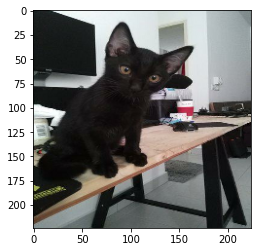

In [ ]:
#1분정도
train_ids = train_df['PetID'].values
empty_image = np.zeros((224,224,3), dtype=np.uint8)
Image.fromarray(empty_image).save('train_images/empty.jpg')
all_imgs = glob.glob('train_images/*.jpg')
train_img_paths = []
for id in tqdm(train_ids):
    temp = [x for x in all_imgs if id in x]
    train_img_paths.append(temp)
train_img_paths = np.array(train_img_paths)
print(train_img_paths[0][0])
plt.imshow(preprocess_img(train_img_paths[0][0]))

In [ ]:
#Custom cnn_module 따로 정의한다
def cnn_module(img_size=224, dim=32, kernel_size=7, head_dim=None, head_activation=None):
    inp = tf.keras.Input((img_size, img_size, 3))
    x = inp
    # x = tf.keras.layers.Normalization(mean=[0.485, 0.456, 0.406], variance=[0.229**2, 0.224**2, 0.225**2])(inp)
    x = tf.keras.layers.Conv2D(dim,kernel_size=kernel_size,strides=4,padding='same',activation='relu')(x)
    
    x = tf.keras.layers.Conv2D(dim*2,kernel_size=kernel_size,padding='same',activation='relu')(x)
    x = tf.keras.layers.Conv2D(dim*2,kernel_size=kernel_size,padding='same',activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    
    x = tf.keras.layers.Conv2D(dim*4,kernel_size=kernel_size,padding='same',activation='relu')(x)
    x = tf.keras.layers.Conv2D(dim*4,kernel_size=kernel_size,padding='same',activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    
    x = tf.keras.layers.Conv2D(dim*8,kernel_size=kernel_size,padding='same',activation='relu')(x)
    x = tf.keras.layers.Conv2D(dim*8,kernel_size=kernel_size,padding='same',activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    
    x = tf.keras.layers.Conv2D(dim*16,kernel_size=kernel_size,padding='same',activation='relu')(x)
    x = tf.keras.layers.Conv2D(dim*16,kernel_size=kernel_size,padding='same',activation='relu')(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    if head_dim is not None:
        x = tf.keras.layers.Dense(head_dim, activation=head_activation)(x)
    return tf.keras.Model(inp, x)

def from_pretrained(model_name, img_size, head_dim=None, head_activation=None, trainable=True, include_preprocessing=False):
    inp = tf.keras.layers.Input(shape = [img_size, img_size, 3])
    img_backbone = tfimm.create_model(model_name, pretrained='timm', nb_classes=0)
    img_backbone.trainable = trainable
    if include_preprocessing:
        preprocess = tfimm.create_preprocessing(model_name, dtype="float32")
        x = preprocess(255*inp)
    else:
        x = inp
    x = img_backbone(x)
    if head_dim is not None:
        x = tf.keras.layers.Dense(head_dim, activation=head_activation)(x)
    return tf.keras.Model(inp, x)

def multimodal_model(models_list, hidden_dim=128, num_hidden_layers=1, head_dim=None, head_activation=None):
    inputs = [model.input for model in models_list]
    outputs = [model.output for model in models_list]
    x = tf.keras.layers.Concatenate(-1)(outputs)
    for _ in range(num_hidden_layers):
        x = tf.keras.layers.Dense(hidden_dim, activation='relu')(x)
    if head_dim is not None:
        x = tf.keras.layers.Dense(head_dim, activation=head_activation)(x)
    return tf.keras.Model(inputs, x)

이미지 크기 결정: 평균값을 봤을 때 384x384가 정보손실이 거의 없음. 실제 구현에서는 224x224에서 성능하락이 없었으므로 모델 속도향상을 위해 224x224선택

In [ ]:
train_measure_df.describe()

,image_height,image_width,text_length
count,14993.000000,14993.000000,14993.000000
mean,385.457586,388.178873,339.313346
std,105.619612,121.591589,373.365160
min,0.000000,0.000000,0.000000
25%,302.153846,328.000000,117.000000
50%,399.250000,380.000000,238.000000
75%,480.000000,400.000000,431.000000
max,1004.800000,672.400000,6664.000000


In [ ]:
tf.keras.backend.clear_session()

epochs = 7
batch_size = 32
lr = 2e-3
weight_decay = 1e-2
img_size = 224

img_train, img_test, _, _ = train_test_split(train_img_paths, train_df[target], test_size=0.3, random_state=SEED, stratify=train_df[target])
X_train, X_test, y_train, y_test = train_test_split(train_df[features].join(train_count_df.drop('PetID',axis=1)).join(train_measure_df.drop('PetID',axis=1)), train_df[target], test_size=0.3, random_state=SEED, stratify=train_df[target])
X_train, X_test, onehot_features = preprocess_input(X_train, X_test, features_to_standardize=con_features + ['RescuerID_count', 'Name_count', 'image_height', 'image_width', 'text_length'], features_to_onehot=cat_features, return_onehot_names=True)
train_ds = get_ds(X_train, y_train, batch_size=batch_size, repeat=True, shuffle=True, encode_y_fn=tf_encode_onehot, img_path=tf.ragged.constant(img_train), img_size=img_size, augment=True)
valid_ds = get_ds(X_test, y_test, batch_size=batch_size, repeat=False, shuffle=False, encode_y_fn=tf_encode_onehot, img_path=tf.ragged.constant(img_test), img_size=img_size)
print(train_ds)

steps_per_epoch = len(X_train)//batch_size
total_steps = steps_per_epoch*epochs

tabular_model = mlp_module(len(X_train.columns), hidden_sizes=(128,512,128), hidden_activation='relu', head_dim=None, head_activation=None)
img_model = cnn_module(img_size, dim=32, kernel_size=7, head_dim=128, head_activation=None)
model = multimodal_model([tabular_model, img_model], hidden_dim=128, head_dim=5, head_activation='softmax')
model.summary()
sch = tf.keras.optimizers.schedules.CosineDecay(lr, total_steps, alpha=1e-6)
decay_sch = tf.keras.optimizers.schedules.CosineDecay(weight_decay*lr, total_steps, alpha=1e-6)
opt = tfa.optimizers.AdamW(decay_sch, sch) #adam with weight decay
# opt = tfa.optimizers.SGDW(decay_sch, sch, momentum=0.9, nesterov=True) #sgd + nesterov momentum with weight decay
loss = tf.keras.losses.CategoricalCrossentropy()
model.compile(optimizer=opt, loss=loss)
history = model.fit(
    train_ds,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    # callbacks=callbacks,
    validation_data=valid_ds,
)

train_ds = get_ds(X_train, y_train, batch_size=batch_size, repeat=False, shuffle=False, encode_y_fn=tf_encode_onehot, img_path=tf.ragged.constant(img_train), img_size=img_size, augment=False)
summary(model, train_ds, y_train, valid_ds, y_test, tf_decode_onehot)

<PrefetchDataset element_spec=((TensorSpec(shape=(None, 372), dtype=tf.float64, name=None), TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 56, 56, 32)   4736        ['input_2[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 56, 56, 64)   100416      ['con

2DCNN모델이 그다지 좋은 성능을 보이지 못했기 때문에, imagenet pretrained 모델을 이용해 transfer learning을 적용함. 

ResNet50(가장 대표적인 imagenet pretrained모델) 사용

pretrained ResNet모델은 trainable=False, 즉 업데이트를 하지 않을 경우 성능이 더 좋았음.

In [ ]:
tf.keras.backend.clear_session()

epochs = 7
batch_size = 32
lr = 2e-3
weight_decay = 1e-2
img_size = 224

img_train, img_test, _, _ = train_test_split(train_img_paths, train_df[target], test_size=0.3, random_state=SEED, stratify=train_df[target])
X_train, X_test, y_train, y_test = train_test_split(train_df[features].join(train_count_df.drop('PetID',axis=1)).join(train_measure_df.drop('PetID',axis=1)), train_df[target], test_size=0.3, random_state=SEED, stratify=train_df[target])
X_train, X_test, onehot_features = preprocess_input(X_train, X_test, features_to_standardize=con_features + ['RescuerID_count', 'Name_count', 'image_height', 'image_width', 'text_length'], features_to_onehot=cat_features, return_onehot_names=True)
train_ds = get_ds(X_train, y_train, batch_size=batch_size, repeat=True, shuffle=True, encode_y_fn=tf_encode_onehot, img_path=tf.ragged.constant(img_train), img_size=img_size, augment=True)
valid_ds = get_ds(X_test, y_test, batch_size=batch_size, repeat=False, shuffle=False, encode_y_fn=tf_encode_onehot, img_path=tf.ragged.constant(img_test), img_size=img_size)
print(train_ds)


steps_per_epoch = len(X_train)//batch_size
total_steps = steps_per_epoch*epochs

tabular_model = mlp_module(len(X_train.columns), hidden_sizes=(128,512,128), hidden_activation='relu', head_dim=None, head_activation=None)
# img_model = cnn_module(img_size, dim=32, kernel_size=7, head_dim=128, head_activation=None)
img_model = from_pretrained('resnet50', img_size=img_size, head_dim=128, head_activation=None, trainable=False, include_preprocessing=True)
model = multimodal_model([tabular_model, img_model], hidden_dim=128, head_dim=5, head_activation='softmax')
model.summary()
sch = tf.keras.optimizers.schedules.CosineDecay(lr, total_steps, alpha=1e-6)
decay_sch = tf.keras.optimizers.schedules.CosineDecay(weight_decay*lr, total_steps, alpha=1e-6)
opt = tfa.optimizers.AdamW(decay_sch, sch) #adam with weight decay
# opt = tfa.optimizers.SGDW(decay_sch, sch, momentum=0.9, nesterov=True) #sgd + nesterov momentum with weight decay
loss = tf.keras.losses.CategoricalCrossentropy()
model.compile(optimizer=opt, loss=loss)
history = model.fit(
    train_ds,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    # callbacks=callbacks,
    validation_data=valid_ds,
)

train_ds = get_ds(X_train, y_train, batch_size=batch_size, repeat=False, shuffle=False, encode_y_fn=tf_encode_onehot, img_path=tf.ragged.constant(img_train), img_size=img_size, augment=False)
summary(model, train_ds, y_train, valid_ds, y_test, tf_decode_onehot)

<PrefetchDataset element_spec=((TensorSpec(shape=(None, 372), dtype=tf.float64, name=None), TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>


All PyTorch model weights were used when initializing ResNet.
All the weights of ResNet were initialized from the PyTorch model.



Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.math.multiply (TFOpLambda)  (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 tf.cast (TFOpLambda)           (None, 224, 224, 3)  0           ['tf.math.multiply[0][0]']       
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 224, 224, 3)  0           ['tf.cast[0][0]']          

##MLP + MLP(text, count vectorizer)

먼저 문장을 소문자로 변환, 구두점 제거. 특수문자 및 알파벳 아닌 문자들 제거.
이후 각 단어로 쪼갬. 

문장에서 단어의 등장횟수에 따라서 하나의 문장(bag of words)을 10000dimension의 1d vector로 변환.

In [ ]:
tokenizer = tf.keras.layers.TextVectorization(max_tokens=10000,output_mode='count')
tokenizer.adapt(train_df['Description'].fillna('').values)
print(len(tokenizer.get_vocabulary()))
print(tokenizer(['hello, world!']))
tokenizer_ = lambda x: tokenizer(x)

10000
tf.Tensor([[0. 0. 0. ... 0. 0. 0.]], shape=(1, 10000), dtype=float32)


In [ ]:
tf.keras.backend.clear_session()

epochs = 7
batch_size = 32
lr = 2e-3
weight_decay = 1e-2
# img_size = 224

# img_train, img_test, _, _ = train_test_split(train_img_paths, train_df[target], test_size=0.3, random_state=SEED, stratify=train_df[target])
txt_train, txt_test, _, _ = train_test_split(train_df['Description'].fillna(''), train_df[target], test_size=0.3, random_state=SEED, stratify=train_df[target])
X_train, X_test, y_train, y_test = train_test_split(train_df[features].join(train_count_df.drop('PetID',axis=1)).join(train_measure_df.drop('PetID',axis=1)), train_df[target], test_size=0.3, random_state=SEED, stratify=train_df[target])
X_train, X_test, onehot_features = preprocess_input(X_train, X_test, features_to_standardize=con_features + ['RescuerID_count', 'Name_count', 'image_height', 'image_width', 'text_length'], features_to_onehot=cat_features, return_onehot_names=True)
train_ds = get_ds(X_train, y_train, batch_size=batch_size, repeat=True, shuffle=True, encode_y_fn=tf_encode_onehot, txt=txt_train, tokenizer=tokenizer_)#, img_path=tf.ragged.constant(img_train), img_size=img_size, augment=True)
valid_ds = get_ds(X_test, y_test, batch_size=batch_size, repeat=False, shuffle=False, encode_y_fn=tf_encode_onehot, txt=txt_test, tokenizer=tokenizer_)#, img_path=tf.ragged.constant(img_test), img_size=img_size)
print(train_ds)

steps_per_epoch = len(X_train)//batch_size
total_steps = steps_per_epoch*epochs

tabular_model = mlp_module(len(X_train.columns), hidden_sizes=(128,512,128), hidden_activation='relu', head_dim=None, head_activation=None)
# img_model = cnn_module(img_size, dim=32, kernel_size=7, head_dim=128, head_activation=None)
txt_model = mlp_module(len(tokenizer.get_vocabulary()), hidden_sizes=(128,512,128), hidden_activation='relu', head_dim=None, head_activation=None)
# img_model = from_pretrained('resnet50', img_size=img_size, head_dim=128, head_activation=None)
model = multimodal_model([tabular_model, txt_model], hidden_dim=128, head_dim=5, head_activation='softmax')
model.summary()
sch = tf.keras.optimizers.schedules.CosineDecay(lr, total_steps, alpha=1e-6)
decay_sch = tf.keras.optimizers.schedules.CosineDecay(weight_decay*lr, total_steps, alpha=1e-6)
opt = tfa.optimizers.AdamW(decay_sch, sch) #adam with weight decay
# opt = tfa.optimizers.SGDW(decay_sch, sch, momentum=0.9, nesterov=True) #sgd + nesterov momentum with weight decay
loss = tf.keras.losses.CategoricalCrossentropy()
model.compile(optimizer=opt, loss=loss)
history = model.fit(
    train_ds,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    # callbacks=callbacks,
    validation_data=valid_ds,
)

train_ds = get_ds(X_train, y_train, batch_size=batch_size, repeat=False, shuffle=False, encode_y_fn=tf_encode_onehot, txt=txt_train, tokenizer=tokenizer_)#, img_path=tf.ragged.constant(img_train), img_size=img_size, augment=False)
summary(model, train_ds, y_train, valid_ds, y_test, tf_decode_onehot)

<PrefetchDataset element_spec=((TensorSpec(shape=(None, 372), dtype=tf.float64, name=None), TensorSpec(shape=(None, 10000), dtype=tf.float32, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 372)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 10000)]      0           []                               
                                                                                                  
 dense (Dense)                  (None, 128)          47744       ['input_1[0][0]']                
                                                                            

##MLP + RNN(tokenization)

위와 차이점은 각 단어를 대응되는 정수값으로 변환.
따라서 한 문장은 embedding layer를 거치고 난 후 N,D의 2D vector가 됨.

In [ ]:
MAX_LEN = 128
tokenizer = tf.keras.layers.TextVectorization(max_tokens=None,output_mode='int',output_sequence_length=MAX_LEN)
tokenizer.adapt(train_df['Description'].fillna('').values)
print(len(tokenizer.get_vocabulary()))
print(tokenizer(['hello, world!']))
tokenizer_ = lambda x:tf.cond(tf.shape(tokenizer(x))[0]==0, lambda:tokenizer('unk'), lambda:tokenizer(x))

27234
tf.Tensor(
[[757 984   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]], shape=(1, 128), dtype=int64)


In [ ]:
def rnn_module(max_len=512, vocab_size=10000, embed_dim=128, hidden_dim=128, n_layers=2, embedding_matrix=None, embedding_trainable=True, head_dim=None, head_activation=None):
    inp = tf.keras.Input((max_len,))
    x = tf.keras.layers.Embedding(vocab_size, embed_dim, weights=embedding_matrix, trainable=embedding_trainable, mask_zero=False)(inp)
    for i in range(n_layers):
        x = tf.keras.layers.LSTM(hidden_dim, return_sequences=i!=n_layers-1)(x)
    if head_dim is not None:
        x = tf.keras.layers.Dense(head_dim, activation=head_activation)(x)
    return tf.keras.Model(inp, x)

In [ ]:
tf.keras.backend.clear_session()

epochs = 7
batch_size = 32
lr = 2e-3
weight_decay = 1e-2
img_size = 224

# img_train, img_test, _, _ = train_test_split(train_img_paths, train_df[target], test_size=0.3, random_state=SEED, stratify=train_df[target])
txt_train, txt_test, _, _ = train_test_split(train_df['Description'].fillna('unk'), train_df[target], test_size=0.3, random_state=SEED, stratify=train_df[target])
X_train, X_test, y_train, y_test = train_test_split(train_df[features].join(train_count_df.drop('PetID',axis=1)).join(train_measure_df.drop('PetID',axis=1)), train_df[target], test_size=0.3, random_state=SEED, stratify=train_df[target])
X_train, X_test, onehot_features = preprocess_input(X_train, X_test, features_to_standardize=con_features + ['RescuerID_count', 'Name_count', 'image_height', 'image_width', 'text_length'], features_to_onehot=cat_features, return_onehot_names=True)
train_ds = get_ds(X_train, y_train, batch_size=batch_size, repeat=True, shuffle=True, encode_y_fn=tf_encode_onehot, txt=txt_train, tokenizer=tokenizer_)#, img_path=tf.ragged.constant(img_train), img_size=img_size, augment=True)
valid_ds = get_ds(X_test, y_test, batch_size=batch_size, repeat=False, shuffle=False, encode_y_fn=tf_encode_onehot, txt=txt_test, tokenizer=tokenizer_)#, img_path=tf.ragged.constant(img_test), img_size=img_size)
print(train_ds)

steps_per_epoch = len(X_train)//batch_size
total_steps = steps_per_epoch*epochs

tabular_model = mlp_module(len(X_train.columns), hidden_sizes=(128,512,128), hidden_activation='relu', head_dim=None, head_activation=None)
# img_model = cnn_module(img_size, dim=32, kernel_size=7, head_dim=128, head_activation=None)
txt_model = rnn_module(MAX_LEN, vocab_size=len(tokenizer.get_vocabulary()), embed_dim=128, hidden_dim=128, n_layers=2, head_dim=128, head_activation=None)
# img_model = from_pretrained('resnet50', img_size=img_size, head_dim=128, head_activation=None)
model = multimodal_model([tabular_model, txt_model], hidden_dim=128, head_dim=5, head_activation='softmax')
model.summary()
sch = tf.keras.optimizers.schedules.CosineDecay(lr, total_steps, alpha=1e-6)
decay_sch = tf.keras.optimizers.schedules.CosineDecay(weight_decay*lr, total_steps, alpha=1e-6)
opt = tfa.optimizers.AdamW(decay_sch, sch) #adam with weight decay
# opt = tfa.optimizers.SGDW(decay_sch, sch, momentum=0.9, nesterov=True) #sgd + nesterov momentum with weight decay
loss = tf.keras.losses.CategoricalCrossentropy()
model.compile(optimizer=opt, loss=loss)
history = model.fit(
    train_ds,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    # callbacks=callbacks,
    validation_data=valid_ds,
)

train_ds = get_ds(X_train, y_train, batch_size=batch_size, repeat=False, shuffle=False, encode_y_fn=tf_encode_onehot, txt=txt_train, tokenizer=tokenizer_)#, img_path=tf.ragged.constant(img_train), img_size=img_size, augment=False)
summary(model, train_ds, y_train, valid_ds, y_test, tf_decode_onehot)

<PrefetchDataset element_spec=((TensorSpec(shape=(None, 372), dtype=tf.float64, name=None), TensorSpec(shape=(None, None), dtype=tf.int64, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 372)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 128, 128)     3485952     ['input_2[0][0]']                
                                                                               

Word2Vec적용

구글에서 학습시킨 word2vec 단어임베딩을 불러옴.

In [ ]:
#약 5~10분
!pip install -q gensim
import gensim.downloader

word2vec = gensim.downloader.load('word2vec-google-news-300')

In [ ]:
VOCAB_SIZE = len(tokenizer.get_vocabulary())
EMBEDDING_DIM = 300

embedding_matrix = tf.random.uniform((VOCAB_SIZE,EMBEDDING_DIM),0,0).numpy()

added=0
for word, idx in zip(tokenizer.get_vocabulary(),range(VOCAB_SIZE)):
    embedding_vector = word2vec[word] if word in word2vec else None
    if embedding_vector is not None:
        embedding_matrix[idx] = embedding_vector
        added += 1
        
print(embedding_matrix.shape)
print(added)

(27234, 300)
13594


In [ ]:
tf.keras.backend.clear_session()

epochs = 7
batch_size = 32
lr = 2e-3
weight_decay = 1e-2
img_size = 224

# img_train, img_test, _, _ = train_test_split(train_img_paths, train_df[target], test_size=0.3, random_state=SEED, stratify=train_df[target])
txt_train, txt_test, _, _ = train_test_split(train_df['Description'].fillna('unk'), train_df[target], test_size=0.3, random_state=SEED, stratify=train_df[target])
X_train, X_test, y_train, y_test = train_test_split(train_df[features].join(train_count_df.drop('PetID',axis=1)).join(train_measure_df.drop('PetID',axis=1)), train_df[target], test_size=0.3, random_state=SEED, stratify=train_df[target])
X_train, X_test, onehot_features = preprocess_input(X_train, X_test, features_to_standardize=con_features + ['RescuerID_count', 'Name_count', 'image_height', 'image_width', 'text_length'], features_to_onehot=cat_features, return_onehot_names=True)
train_ds = get_ds(X_train, y_train, batch_size=batch_size, repeat=True, shuffle=True, encode_y_fn=tf_encode_onehot, txt=txt_train, tokenizer=tokenizer_)#, img_path=tf.ragged.constant(img_train), img_size=img_size, augment=True)
valid_ds = get_ds(X_test, y_test, batch_size=batch_size, repeat=False, shuffle=False, encode_y_fn=tf_encode_onehot, txt=txt_test, tokenizer=tokenizer_)#, img_path=tf.ragged.constant(img_test), img_size=img_size)
print(train_ds)

steps_per_epoch = len(X_train)//batch_size
total_steps = steps_per_epoch*epochs

tabular_model = mlp_module(len(X_train.columns), hidden_sizes=(128,512,128), hidden_activation='relu', head_dim=None, head_activation=None)
# img_model = cnn_module(img_size, dim=32, kernel_size=7, head_dim=128, head_activation=None)
txt_model = rnn_module(MAX_LEN, vocab_size=len(tokenizer.get_vocabulary()), embed_dim=300, hidden_dim=128, n_layers=2, embedding_matrix=[embedding_matrix], embedding_trainable=True, head_dim=128, head_activation=None)
# img_model = from_pretrained('resnet50', img_size=img_size, head_dim=128, head_activation=None)
model = multimodal_model([tabular_model, txt_model], hidden_dim=128, head_dim=5, head_activation='softmax')
model.summary()
sch = tf.keras.optimizers.schedules.CosineDecay(lr, total_steps, alpha=1e-6)
decay_sch = tf.keras.optimizers.schedules.CosineDecay(weight_decay*lr, total_steps, alpha=1e-6)
opt = tfa.optimizers.AdamW(decay_sch, sch) #adam with weight decay
# opt = tfa.optimizers.SGDW(decay_sch, sch, momentum=0.9, nesterov=True) #sgd + nesterov momentum with weight decay
loss = tf.keras.losses.CategoricalCrossentropy()
model.compile(optimizer=opt, loss=loss)
history = model.fit(
    train_ds,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    # callbacks=callbacks,
    validation_data=valid_ds,
)

train_ds = get_ds(X_train, y_train, batch_size=batch_size, repeat=False, shuffle=False, encode_y_fn=tf_encode_onehot, txt=txt_train, tokenizer=tokenizer_)#, img_path=tf.ragged.constant(img_train), img_size=img_size, augment=False)
summary(model, train_ds, y_train, valid_ds, y_test, tf_decode_onehot)

<PrefetchDataset element_spec=((TensorSpec(shape=(None, 372), dtype=tf.float64, name=None), TensorSpec(shape=(None, None), dtype=tf.int64, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 372)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 128, 300)     8170200     ['input_2[0][0]']                
                                                                               

문장을 1D vector로 변환한 것보다 2D벡터로 변환한 것이 성능이 더 떨어짐.

제일 큰 원인은 RNN구조가 그다지 좋은 성능을 보이지 못하는 점때문으로 보임.

##MLP + MLP(txt) + 2DCNN(image)

In [ ]:
tokenizer = tf.keras.layers.TextVectorization(max_tokens=10000,output_mode='count')
tokenizer.adapt(train_df['Description'].fillna('').values)
print(len(tokenizer.get_vocabulary()))
print(tokenizer(['hello, world!']))
tokenizer_ = lambda x: tokenizer(x)

10000
tf.Tensor([[0. 0. 0. ... 0. 0. 0.]], shape=(1, 10000), dtype=float32)


In [ ]:
tf.keras.backend.clear_session()

epochs = 7
batch_size = 32
lr = 2e-3
weight_decay = 1e-2
img_size = 224

img_train, img_test, _, _ = train_test_split(train_img_paths, train_df[target], test_size=0.3, random_state=SEED, stratify=train_df[target])
txt_train, txt_test, _, _ = train_test_split(train_df['Description'].fillna(''), train_df[target], test_size=0.3, random_state=SEED, stratify=train_df[target])
X_train, X_test, y_train, y_test = train_test_split(train_df[features].join(train_count_df.drop('PetID',axis=1)).join(train_measure_df.drop('PetID',axis=1)), train_df[target], test_size=0.3, random_state=SEED, stratify=train_df[target])
X_train, X_test, onehot_features = preprocess_input(X_train, X_test, features_to_standardize=con_features + ['RescuerID_count', 'Name_count', 'image_height', 'image_width', 'text_length'], features_to_onehot=cat_features, return_onehot_names=True)
train_ds = get_ds(X_train, y_train, batch_size=batch_size, repeat=True, shuffle=True, encode_y_fn=tf_encode_onehot, txt=txt_train, tokenizer=tokenizer_, img_path=tf.ragged.constant(img_train), img_size=img_size, augment=True)
valid_ds = get_ds(X_test, y_test, batch_size=batch_size, repeat=False, shuffle=False, encode_y_fn=tf_encode_onehot, txt=txt_test, tokenizer=tokenizer_, img_path=tf.ragged.constant(img_test), img_size=img_size)
print(train_ds)

steps_per_epoch = len(X_train)//batch_size
total_steps = steps_per_epoch*epochs

tabular_model = mlp_module(len(X_train.columns), hidden_sizes=(128,512,128), hidden_activation='relu', head_dim=None, head_activation=None)
# img_model = cnn_module(img_size, dim=32, kernel_size=7, head_dim=128, head_activation=None)
txt_model = mlp_module(len(tokenizer.get_vocabulary()), hidden_sizes=(128,512,128), hidden_activation='relu', head_dim=None, head_activation=None)
img_model = from_pretrained('resnet50', img_size=img_size, head_dim=128, head_activation=None, trainable=False, include_preprocessing=True)
model = multimodal_model([tabular_model, img_model, txt_model], hidden_dim=128, num_hidden_layers=2, head_dim=5, head_activation='softmax')
model.summary()
sch = tf.keras.optimizers.schedules.CosineDecay(lr, total_steps, alpha=1e-6)
decay_sch = tf.keras.optimizers.schedules.CosineDecay(weight_decay*lr, total_steps, alpha=1e-6)
opt = tfa.optimizers.AdamW(decay_sch, sch) #adam with weight decay
# opt = tfa.optimizers.SGDW(decay_sch, sch, momentum=0.9, nesterov=True) #sgd + nesterov momentum with weight decay
loss = tf.keras.losses.CategoricalCrossentropy()
model.compile(optimizer=opt, loss=loss)
history = model.fit(
    train_ds,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    # callbacks=callbacks,
    validation_data=valid_ds,
)

train_ds = get_ds(X_train, y_train, batch_size=batch_size, repeat=False, shuffle=False, encode_y_fn=tf_encode_onehot, txt=txt_train, tokenizer=tokenizer_, img_path=tf.ragged.constant(img_train), img_size=img_size, augment=False)
summary(model, train_ds, y_train, valid_ds, y_test, tf_decode_onehot)

<PrefetchDataset element_spec=((TensorSpec(shape=(None, 372), dtype=tf.float64, name=None), TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10000), dtype=tf.float32, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>


All PyTorch model weights were used when initializing ResNet.
All the weights of ResNet were initialized from the PyTorch model.



Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.math.multiply (TFOpLambda)  (None, 224, 224, 3)  0           ['input_3[0][0]']                
                                                                                                  
 tf.cast (TFOpLambda)           (None, 224, 224, 3)  0           ['tf.math.multiply[0][0]']       
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 224, 224, 3)  0           ['tf.cast[0][0]']          

concat이후에 hidden layer을 두개로 했을 때 더 좋은 성능.

# Cross validation, test submission, 최종 정리

In [ ]:
tokenizer = tf.keras.layers.TextVectorization(max_tokens=10000,output_mode='count')
tokenizer.adapt(train_df['Description'].fillna('').values)
print(len(tokenizer.get_vocabulary()))
print(tokenizer(['hello, world!']))
tokenizer_ = lambda x: tokenizer(x)

10000
tf.Tensor([[0. 0. 0. ... 0. 0. 0.]], shape=(1, 10000), dtype=float32)


In [ ]:
tf.keras.backend.clear_session()

epochs = 7
batch_size = 32
lr = 2e-3
weight_decay = 1e-2
img_size = 224

kfold = sklearn.model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
scores = []
for fold, (train_idx, valid_idx) in enumerate(kfold.split(train_df, train_df[target])):
    print(f'---------fold{fold}---------')

    # img_train, img_test, _, _ = train_test_split(train_img_paths, train_df[target], test_size=0.3, random_state=SEED, stratify=train_df[target])
    # txt_train, txt_test, _, _ = train_test_split(train_df['Description'].fillna(''), train_df[target], test_size=0.3, random_state=SEED, stratify=train_df[target])
    # X_train, X_test, y_train, y_test = train_test_split(train_df[features].join(train_count_df.drop('PetID',axis=1)).join(train_measure_df.drop('PetID',axis=1)), train_df[target], test_size=0.3, random_state=SEED, stratify=train_df[target])
    img_train, img_test = train_img_paths[train_idx], train_img_paths[valid_idx]
    txt_train, txt_test = train_df['Description'].fillna('')[train_idx], train_df['Description'].fillna('')[valid_idx]
    train = train_df[features].join(train_count_df.drop('PetID',axis=1)).join(train_measure_df.drop('PetID',axis=1))
    X_train, X_test, y_train, y_test = train.iloc[train_idx], train.iloc[valid_idx], train_df[target][train_idx], train_df[target][valid_idx]

    X_train, X_test, onehot_features = preprocess_input(X_train, X_test, features_to_standardize=con_features + ['RescuerID_count', 'Name_count', 'image_height', 'image_width', 'text_length'], features_to_onehot=cat_features, return_onehot_names=True)
    train_ds = get_ds(X_train, y_train, batch_size=batch_size, repeat=True, shuffle=True, encode_y_fn=tf_encode_onehot, txt=txt_train, tokenizer=tokenizer_, img_path=tf.ragged.constant(img_train), img_size=img_size, augment=True)
    valid_ds = get_ds(X_test, y_test, batch_size=batch_size, repeat=False, shuffle=False, encode_y_fn=tf_encode_onehot, txt=txt_test, tokenizer=tokenizer_, img_path=tf.ragged.constant(img_test), img_size=img_size)
    print(train_ds)

    steps_per_epoch = len(X_train)//batch_size
    total_steps = steps_per_epoch*epochs

    tabular_model = mlp_module(len(X_train.columns), hidden_sizes=(128,512,128), hidden_activation='relu', head_dim=None, head_activation=None)
    # img_model = cnn_module(img_size, dim=32, kernel_size=7, head_dim=128, head_activation=None)
    txt_model = mlp_module(len(tokenizer.get_vocabulary()), hidden_sizes=(128,512,128), hidden_activation='relu', head_dim=None, head_activation=None)
    img_model = from_pretrained('resnet50', img_size=img_size, head_dim=128, head_activation=None, trainable=False, include_preprocessing=True)
    model = multimodal_model([tabular_model, img_model, txt_model], hidden_dim=128, num_hidden_layers=2, head_dim=5, head_activation='softmax')

    sch = tf.keras.optimizers.schedules.CosineDecay(lr, total_steps, alpha=1e-6)
    decay_sch = tf.keras.optimizers.schedules.CosineDecay(weight_decay*lr, total_steps, alpha=1e-6)
    opt = tfa.optimizers.AdamW(decay_sch, sch) #adam with weight decay
    # opt = tfa.optimizers.SGDW(decay_sch, sch, momentum=0.9, nesterov=True) #sgd + nesterov momentum with weight decay
    loss = tf.keras.losses.CategoricalCrossentropy()
    model.compile(optimizer=opt, loss=loss)
    history = model.fit(
        train_ds,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        # callbacks=callbacks,
        validation_data=valid_ds,
    )

    train_ds = get_ds(X_train, y_train, batch_size=batch_size, repeat=False, shuffle=False, encode_y_fn=tf_encode_onehot, txt=txt_train, tokenizer=tokenizer_, img_path=tf.ragged.constant(img_train), img_size=img_size, augment=False)
    scores.append(summary(model, train_ds, y_train, valid_ds, y_test, tf_decode_onehot))

---------fold0---------
<PrefetchDataset element_spec=((TensorSpec(shape=(None, 372), dtype=tf.float64, name=None), TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10000), dtype=tf.float32, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>


All PyTorch model weights were used when initializing ResNet.
All the weights of ResNet were initialized from the PyTorch model.



Epoch 1/7
374/374 [==============================] - 16s 32ms/step - loss: 1.4261 - val_loss: 1.3585
Epoch 2/7
374/374 [==============================] - 10s 26ms/step - loss: 1.3345 - val_loss: 1.3666
Epoch 3/7
374/374 [==============================] - 14s 37ms/step - loss: 1.1478 - val_loss: 1.3957
Epoch 4/7
374/374 [==============================] - 10s 26ms/step - loss: 0.9030 - val_loss: 1.5475
Epoch 5/7
374/374 [==============================] - 10s 26ms/step - loss: 0.7189 - val_loss: 1.5752
Epoch 6/7
374/374 [==============================] - 10s 26ms/step - loss: 0.6144 - val_loss: 1.6107
Epoch 7/7
374/374 [==============================] - 10s 26ms/step - loss: 0.6088 - val_loss: 1.6224
Functional
375/375 [==============================] - 7s 18ms/step
===train result===
acc:0.9035
mae:0.1241
cohen's kappa:0.9284
94/94 [==============================] - 2s 17ms/step
===valid result===
acc:0.3998
mae:0.8863
cohen's kappa:0.3489

---------fold1---------
<PrefetchDataset elemen

All PyTorch model weights were used when initializing ResNet.
All the weights of ResNet were initialized from the PyTorch model.



Epoch 1/7
374/374 [==============================] - 13s 28ms/step - loss: 1.4344 - val_loss: 1.3752
Epoch 2/7
374/374 [==============================] - 10s 26ms/step - loss: 1.3551 - val_loss: 1.3443
Epoch 3/7
374/374 [==============================] - 10s 27ms/step - loss: 1.2613 - val_loss: 1.3540
Epoch 4/7
374/374 [==============================] - 10s 26ms/step - loss: 1.1260 - val_loss: 1.4033
Epoch 5/7
374/374 [==============================] - 10s 26ms/step - loss: 0.9722 - val_loss: 1.4403
Epoch 6/7
374/374 [==============================] - 10s 27ms/step - loss: 0.8656 - val_loss: 1.4773
Epoch 7/7
374/374 [==============================] - 10s 26ms/step - loss: 0.7544 - val_loss: 1.4899
Functional
375/375 [==============================] - 7s 17ms/step
===train result===
acc:0.8431
mae:0.2019
cohen's kappa:0.8806
94/94 [==============================] - 2s 18ms/step
===valid result===
acc:0.4025
mae:0.8966
cohen's kappa:0.3506

---------fold2---------
<PrefetchDataset elemen

All PyTorch model weights were used when initializing ResNet.
All the weights of ResNet were initialized from the PyTorch model.



Epoch 1/7
374/374 [==============================] - 15s 30ms/step - loss: 1.4345 - val_loss: 1.3597
Epoch 2/7
374/374 [==============================] - 10s 27ms/step - loss: 1.3650 - val_loss: 1.3316
Epoch 3/7
374/374 [==============================] - 10s 27ms/step - loss: 1.2823 - val_loss: 1.3601
Epoch 4/7
374/374 [==============================] - 10s 27ms/step - loss: 1.1451 - val_loss: 1.3685
Epoch 5/7
374/374 [==============================] - 10s 27ms/step - loss: 1.0117 - val_loss: 1.4252
Epoch 6/7
374/374 [==============================] - 10s 27ms/step - loss: 0.8225 - val_loss: 1.5380
Epoch 7/7
374/374 [==============================] - 10s 26ms/step - loss: 0.8047 - val_loss: 1.4919
Functional
375/375 [==============================] - 7s 18ms/step
===train result===
acc:0.8218
mae:0.2360
cohen's kappa:0.8558
94/94 [==============================] - 2s 17ms/step
===valid result===
acc:0.4081
mae:0.9100
cohen's kappa:0.3637

---------fold3---------
<PrefetchDataset elemen

All PyTorch model weights were used when initializing ResNet.
All the weights of ResNet were initialized from the PyTorch model.



Epoch 1/7
374/374 [==============================] - 13s 28ms/step - loss: 1.4271 - val_loss: 1.3690
Epoch 2/7
374/374 [==============================] - 10s 27ms/step - loss: 1.3650 - val_loss: 1.3375
Epoch 3/7
374/374 [==============================] - 10s 26ms/step - loss: 1.2577 - val_loss: 1.3758
Epoch 4/7
374/374 [==============================] - 10s 26ms/step - loss: 1.1183 - val_loss: 1.4251
Epoch 5/7
374/374 [==============================] - 10s 27ms/step - loss: 1.0056 - val_loss: 1.4158
Epoch 6/7
374/374 [==============================] - 10s 26ms/step - loss: 0.8300 - val_loss: 1.5126
Epoch 7/7
374/374 [==============================] - 10s 26ms/step - loss: 0.8096 - val_loss: 1.5062
Functional
375/375 [==============================] - 8s 18ms/step
===train result===
acc:0.8366
mae:0.2263
cohen's kappa:0.8455
94/94 [==============================] - 2s 18ms/step
===valid result===
acc:0.4063
mae:0.9189
cohen's kappa:0.3396

---------fold4---------
<PrefetchDataset elemen

All PyTorch model weights were used when initializing ResNet.
All the weights of ResNet were initialized from the PyTorch model.



Epoch 1/7
374/374 [==============================] - 14s 28ms/step - loss: 1.4406 - val_loss: 1.3813
Epoch 2/7
374/374 [==============================] - 10s 26ms/step - loss: 1.3762 - val_loss: 1.3346
Epoch 3/7
374/374 [==============================] - 10s 26ms/step - loss: 1.2896 - val_loss: 1.3143
Epoch 4/7
374/374 [==============================] - 10s 26ms/step - loss: 1.1689 - val_loss: 1.3518
Epoch 5/7
374/374 [==============================] - 10s 26ms/step - loss: 1.0444 - val_loss: 1.3673
Epoch 6/7
374/374 [==============================] - 10s 26ms/step - loss: 0.9239 - val_loss: 1.4088
Epoch 7/7
374/374 [==============================] - 10s 26ms/step - loss: 0.9047 - val_loss: 1.3965
Functional
375/375 [==============================] - 7s 18ms/step
===train result===
acc:0.8196
mae:0.2459
cohen's kappa:0.8446
94/94 [==============================] - 2s 18ms/step
===valid result===
acc:0.4083
mae:0.9023
cohen's kappa:0.3657



In [ ]:
cv = pd.DataFrame.from_dict([x[1] for x in scores])
cv.index.name='fold'

print(cv.mean())
cv

acc              0.404989
mae              0.902822
cohen's kappa    0.353721
dtype: float64


,acc,mae,cohen's kappa
fold,,,
0,0.399800,0.886295,0.348949
1,0.402467,0.896632,0.350644
2,0.408136,0.909970,0.363711
3,0.406271,0.918946,0.339610
4,0.408272,0.902268,0.365692


  0%|          | 0/3972 [00:00<?, ?it/s]

/tmp/ipykernel_4689/580356672.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  test_img_paths = np.array(test_img_paths)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


test_images/e2dfc2935-2.jpg


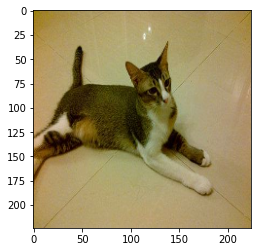

In [ ]:
test_df = pd.read_csv('test/test.csv')
#약 20분
try:
    test_measure_df = pd.read_csv('test_measure_df.csv', index_col=0)
except:
    test_measure_df = test_df[['PetID']].copy()
    height = []
    width = []
    for id in tqdm(test_df['PetID']):
        imgs_path = glob.glob(f'test_images/{id}-*.jpg')
        if len(imgs_path):
            hs = []
            ws = []
            for path in imgs_path:
                h, w = tf.keras.utils.img_to_array(tf.keras.utils.load_img(path), 'channels_last').shape[:2]
                hs.append(h)
                ws.append(w)
            height.append(np.mean(hs))
            width.append(np.mean(ws))
        else:
            height.append(np.nan)
            width.append(np.nan)
    test_measure_df['image_height'] = height
    test_measure_df['image_width'] = width
    test_measure_df['image_height'] = test_measure_df['image_height'].fillna(0)
    test_measure_df['image_width'] = test_measure_df['image_width'].fillna(0)
    test_measure_df['text_length'] = test_df['Description'].fillna('').apply(len)
    test_measure_df.to_csv('test_measure_df.csv')

    
#rescuer id와 name은 nan인 경우가 있음. 이경우 0으로 대체함.
test_count_df = test_df[['PetID']].copy()
test_count_df['RescuerID_count'] = test_df['RescuerID'].map(test_df['RescuerID'].value_counts().to_dict())
test_count_df['Name_count'] = test_df['Name'].map(test_df['Name'].value_counts().to_dict())
test_count_df['RescuerID_count'] = test_count_df['RescuerID_count'].fillna(0)
test_count_df['Name_count'] = test_count_df['Name_count'].fillna(0)


test_ids = test_df['PetID'].values
# empty_image = np.zeros((224,224,3), dtype=np.uint8)
# Image.fromarray(empty_image).save('train_images/empty.jpg')
all_imgs = glob.glob('test_images/*.jpg')
test_img_paths = []
for id in tqdm(test_ids):
    temp = [x for x in all_imgs if id in x]
    test_img_paths.append(temp)
test_img_paths = np.array(test_img_paths)
print(test_img_paths[0][0])
plt.imshow(preprocess_img(test_img_paths[0][0]))

In [ ]:
tf.keras.backend.clear_session()

epochs = 7
batch_size = 32
lr = 2e-3
weight_decay = 1e-2
img_size = 224

# img_train, img_test, _, _ = train_test_split(train_img_paths, train_df[target], test_size=0.3, random_state=SEED, stratify=train_df[target])
# txt_train, txt_test, _, _ = train_test_split(train_df['Description'].fillna(''), train_df[target], test_size=0.3, random_state=SEED, stratify=train_df[target])
# X_train, X_test, y_train, y_test = train_test_split(train_df[features].join(train_count_df.drop('PetID',axis=1)).join(train_measure_df.drop('PetID',axis=1)), train_df[target], test_size=0.3, random_state=SEED, stratify=train_df[target])
img_train, img_test = train_img_paths, test_img_paths
txt_train, txt_test = train_df['Description'].fillna(''), test_df['Description'].fillna('')
X_train = train_df[features].join(train_count_df.drop('PetID',axis=1)).join(train_measure_df.drop('PetID',axis=1))
X_test = test_df[features].join(test_count_df.drop('PetID',axis=1)).join(test_measure_df.drop('PetID',axis=1))

X_train, X_test, onehot_features = preprocess_input(X_train, X_test, features_to_standardize=con_features + ['RescuerID_count', 'Name_count', 'image_height', 'image_width', 'text_length'], features_to_onehot=cat_features, return_onehot_names=True)
train_ds = get_ds(X_train, y_train, batch_size=batch_size, repeat=True, shuffle=True, encode_y_fn=tf_encode_onehot, txt=txt_train, tokenizer=tokenizer_, img_path=tf.ragged.constant(img_train), img_size=img_size, augment=True)
test_ds = get_ds(X_test, y_test, batch_size=batch_size, repeat=False, shuffle=False, encode_y_fn=tf_encode_onehot, txt=txt_test, tokenizer=tokenizer_, img_path=tf.ragged.constant(img_test), img_size=img_size)
print(train_ds)

steps_per_epoch = len(X_train)//batch_size
total_steps = steps_per_epoch*epochs

tabular_model = mlp_module(len(X_train.columns), hidden_sizes=(128,512,128), hidden_activation='relu', head_dim=None, head_activation=None)
# img_model = cnn_module(img_size, dim=32, kernel_size=7, head_dim=128, head_activation=None)
txt_model = mlp_module(len(tokenizer.get_vocabulary()), hidden_sizes=(128,512,128), hidden_activation='relu', head_dim=None, head_activation=None)
img_model = from_pretrained('resnet50', img_size=img_size, head_dim=128, head_activation=None, trainable=False, include_preprocessing=True)
model = multimodal_model([tabular_model, img_model, txt_model], hidden_dim=128, num_hidden_layers=2, head_dim=5, head_activation='softmax')
model.summary()
sch = tf.keras.optimizers.schedules.CosineDecay(lr, total_steps, alpha=1e-6)
decay_sch = tf.keras.optimizers.schedules.CosineDecay(weight_decay*lr, total_steps, alpha=1e-6)
opt = tfa.optimizers.AdamW(decay_sch, sch) #adam with weight decay
# opt = tfa.optimizers.SGDW(decay_sch, sch, momentum=0.9, nesterov=True) #sgd + nesterov momentum with weight decay
loss = tf.keras.losses.CategoricalCrossentropy()
model.compile(optimizer=opt, loss=loss)
history = model.fit(
    train_ds,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    # callbacks=callbacks,
    # validation_data=valid_ds,
)

train_ds = get_ds(X_train, y_train, batch_size=batch_size, repeat=False, shuffle=False, encode_y_fn=tf_encode_onehot, txt=txt_train, tokenizer=tokenizer_, img_path=tf.ragged.constant(img_train), img_size=img_size, augment=False)
# summary(model, train_ds, y_train, None, None, tf_decode_onehot)

<PrefetchDataset element_spec=((TensorSpec(shape=(None, 392), dtype=tf.float64, name=None), TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10000), dtype=tf.float32, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>


All PyTorch model weights were used when initializing ResNet.
All the weights of ResNet were initialized from the PyTorch model.



Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.math.multiply (TFOpLambda)  (None, 224, 224, 3)  0           ['input_3[0][0]']                
                                                                                                  
 tf.cast (TFOpLambda)           (None, 224, 224, 3)  0           ['tf.math.multiply[0][0]']       
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 224, 224, 3)  0           ['tf.cast[0][0]']          

In [ ]:
submission=pd.read_csv('test/sample_submission.csv')

submission

,PetID,AdoptionSpeed
0,e2dfc2935,0
1,f153b465f,0
2,3c90f3f54,0
3,e02abc8a3,0
4,09f0df7d1,0
...,...,...
3967,ae57f8d52,0
3968,83432904d,0
3969,399013029,0
3970,fd80b8c80,0


In [ ]:
test_ds = get_ds(X_test, np.zeros((len(X_test),), dtype='int'), batch_size=batch_size, repeat=False, shuffle=False, encode_y_fn=tf_encode_onehot, txt=txt_test, tokenizer=tokenizer_, img_path=tf.ragged.constant(img_test), img_size=img_size)
test_prediction = np.argmax(model.predict(test_ds), axis=-1)
submission['AdoptionSpeed'] = test_prediction
submission.to_csv('submission.csv')

102/125 [=======================>......] - ETA: 3s

In [ ]:
submission